# <a id='toc1_'></a>[Milestone 5](#toc0_)

In [1]:
from utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import os
import csv
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
from IPython.display import Markdown as md

We give a brief overview of some of the libraries our code depended on.

The first few libraries such as pandas, numpy, matplotlib, and seaborn are basic data analysis and visualization libraries we used to develop code. We used libraries including TimeSeriesSplit for the time series section, and StandardScalar to scale the data when performing time series. We also used libraries to help calculate error metrics in our code, including mean_squared_error and r_2 score.

To train models we developed a train_test_split, coming from sklearn.model_selection. From this same library we used GridSearchCV to perform cross validation to find the optimal parameters in our models, using KFold to split the data into folds when doing grid search. Since we developed an XGBoost model, we imported xgb from xgboost as well. In the util.py script we developed a decision tree and random forest, where we also imported those libraries.

**Table of contents**<a id='toc0_'></a>    
- [Milestone 5](#toc1_)    
  - [Background and Motivation](#toc1_1_)    
  - [Data](#toc1_2_)    
  - [Problem Statement](#toc1_3_)    
  - [Exploratory Data Analysis](#toc1_4_)    
    - [Loading the Data](#toc1_4_1_)    
  - [Infotable EDA](#toc1_5_)    
    - [Summary](#toc1_5_1_)    
    - [Missing Values](#toc1_5_2_)    
  - [Coverpage EDA](#toc1_6_)    
    - [Summary](#toc1_6_1_)    
    - [Missing values](#toc1_6_2_)    
  - [Summary Page EDA](#toc1_7_)    
    - [Summary](#toc1_7_1_)    
    - [Numerical Correlations with `TOTAL_VALUE`](#toc1_7_2_)    
      - [Correlating `TOTAL_VALUE` with the summary statistics of the `VALUE` column in `df_info`.](#toc1_7_2_1_)    
      - [Correlating `TOTAL_VALUE` with the summary statistics of the `SSHPRNAMT` column in `df_info`.](#toc1_7_2_2_)    
      - [Heatmap of correlations with logathmically transformed features.](#toc1_7_2_3_)    
      - [Key Correlations Observed](#toc1_7_2_4_)    
      - [Heatmap Insights for Feature Selection](#toc1_7_2_5_)    
      - [Findings from Scatter Plots](#toc1_7_2_6_)    
      - [Geographic Insights](#toc1_7_2_7_)    
  - [Summary](#toc1_8_)    
  - [Modeling](#toc1_9_)    
    - [Dataset Assembly](#toc1_9_1_)    
    - [Data Processing and Feature Engineering](#toc1_9_2_)    
  - [Linear Regression](#toc1_10_)    
  - [Decision Tree](#toc1_11_)    
  - [Random Forest](#toc1_12_)    
  - [XGBoost](#toc1_13_)    
  - [Comparison](#toc1_14_)    
  - [Conclusion](#toc1_15_)    
  - [Appendix: Timeseries Modeling](#toc1_16_)    
    - [Scaling Without Time Series Cross-Validation](#toc1_16_1_)    
    - [Problem Statement](#toc1_16_2_)    
    - [Scaling With Time Series Cross-Validation](#toc1_16_3_)    
      - [Purpose](#toc1_16_3_1_)    
      - [Steps](#toc1_16_3_2_)    
      - [Why Use Time Series Cross-Validation?](#toc1_16_3_3_)    
      - [Why Ridge Regression?](#toc1_16_3_4_)    
      - [Tuning/Parameters](#toc1_16_3_5_)    
      - [Summary of Model Choice](#toc1_16_3_6_)    
    - [Interpretation of the Results (With Log Transformation)](#toc1_16_4_)    
      - [Mean Squared Error (MSE)](#toc1_16_4_1_)    
      - [R² Score](#toc1_16_4_2_)    
    - [Summary of Findings](#toc1_16_5_)    
      - [Mean Squared Error (MSE) Across Folds (Line Plot)](#toc1_16_5_1_)    
      - [Bar Plot of MSE Across Folds](#toc1_16_5_2_)    
      - [Residuals Plot](#toc1_16_5_3_)    
      - [Predicted vs. Actual Values (Last Fold)](#toc1_16_5_4_)    
      - [Residuals Across Folds (Box Plot)](#toc1_16_5_5_)    
    - [Overall Summary](#toc1_16_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Background and Motivation](#toc0_)

The SEC Form 13F, filed quarterly by institutional investors, increases public visibility of their equity holdings. These filings provide a glimpse into the investment strategies of large institutional investors, where Form 13F is a valuable tool for understanding their portfolio decisions and asset/security allocations.

This project aims to analyze these filings from Q2 2013 to Q3 2024 to gain insights into the holdings and strategies of large institutional investors like hedge funds, which typically operate with limited transparency. Examining these quarterly holdings may reveal cross-sectional and time-series trends at both firm and market levels. We hope to utilize variables such as the distribution of the `VALUE` variable, representing the market value of a security/asset, to uncover trends and patterns that may reveal insights into institutional investment strategies.

## <a id='toc1_2_'></a>[Data](#toc0_)

The project will use the Form 13F data, available through the SEC's EDGAR system. This dataset includes filing details such as submission types, filing dates, issuer names, CUSIP numbers, and market values. Despite its relevance in capturing large-scale investment activities, the dataset may contain errors or inconsistencies due to self-reported data. These challenges will be addressed during the EDA phase, with a focus on handling missing or incorrect entries.

We utilize 3 datasets downloaded from the SEC 13F website, including INFOTABLE, COVERPAGE, and SUMMARYPAGE. The INFOTABLE dataset contains information about the securities held by each institution and every row represents a specific asset/security holding repoted in a Form 13F filing such as Value (market value of the asset/security) and SSHPRNAMT (Number of shares or principal amount held). COVERPAGE provides metadata about the Form13F filings, such as the name of the institutional manager and an indicator of the confidential treatment request of a filing is expired. SUMMARYPAGE provides an overall summary of the security filing, such as the total market value of the asset/securities reported in the filing. We also discuss this in the README.md

Overall we will combine these datasets on their primary key, ACCESSION_NUMBER, which is a unique identifier assigned by the SEC to every submission.

Through EDA, we explore the data and conduct data cleaning when necessary, as we anticipated there are many missing values in this dataset we will address.

## <a id='toc1_3_'></a>[Problem Statement](#toc0_)

The research question is: Can we predict the total value of the assets/securities held by an institutional investor based on available features such as information about their location, number of shares held, and summary statistics of the individual holdings. 

## <a id='toc1_4_'></a>[Exploratory Data Analysis](#toc0_)

Before building models, we conduct exploratory data analysis. In this section we observe statistics for each dataframe such as their shape and how much data is missing. We also create visualizations to analyze the data, which can also help in model building.

### <a id='toc1_4_1_'></a>[Loading the Data](#toc0_)

In [2]:
try:
    df_info = pd.read_csv("../data/2024q3/INFOTABLE.tsv", sep="\t", low_memory=False)
except:
    df_info = pd.read_csv("XGBoost/infotable_dataset.csv", low_memory=False)
    
try:
    df_cover = pd.read_csv("XGBoost/coverpage_dataset.csv")
except:
    df_cover = pd.read_csv("../data/2024q3/COVERPAGE.tsv", sep="\t", low_memory=False)
    
try: 
    df_summary = pd.read_csv("XGBoost/summarypage_dataset.csv")
except:
    df_summary = pd.read_csv("../data/2024q3/SUMMARYPAGE.tsv", sep="\t", low_memory=False)

In [3]:
print(f"Infotable has {len(df_info)} rows.")

Infotable has 3278515 rows.


In [4]:
print(f"Coverpage has {len(df_cover)} rows.")

Coverpage has 10117 rows.


In [5]:
print(f"Summarypage has {len(df_summary)} rows.")

Summarypage has 8244 rows.


We can see that Infotable has by far the largest number of rows, most likely because this dataset represents a single security holding reported in a Form 13F filing, so there would be many unique securities held by institutional managers in their portfolios. Coverpage would have fewer rows since it just includes metadata regarding the Form 13F filing like the institutional managers name, where there wouldn't be as many. Summarypage also has fewer rows since its just an aggregate summary and overview of securities reported.

## <a id='toc1_5_'></a>[Infotable EDA](#toc0_)

<a id="summaryinfo"></a>

### <a id='toc1_5_1_'></a>[Summary](#toc0_)

In this summary section we look at basic information about the INFOTABLE dataset including its shape, data types, and descriptive statistics.

In [6]:
df_info.shape

(3278515, 15)

We see that the shape of the dataset for INFOTABLE contains 3278515 rows and 15 columns. We can further observe the data types for INFOTABLE:

In [7]:
print(df_info.dtypes)

ACCESSION_NUMBER        object
INFOTABLE_SK             int64
NAMEOFISSUER            object
TITLEOFCLASS            object
CUSIP                   object
FIGI                    object
VALUE                    int64
SSHPRNAMT                int64
SSHPRNAMTTYPE           object
PUTCALL                 object
INVESTMENTDISCRETION    object
OTHERMANAGER            object
VOTING_AUTH_SOLE         int64
VOTING_AUTH_SHARED       int64
VOTING_AUTH_NONE         int64
dtype: object


Next, we look at the descriptive statistics for the numerical columns.

In [8]:
print(df_info.describe())

       INFOTABLE_SK         VALUE     SSHPRNAMT  VOTING_AUTH_SOLE  \
count  3.278515e+06  3.278515e+06  3.278515e+06      3.278515e+06   
mean   1.035340e+08  1.789295e+07  2.946283e+05      2.208318e+05   
std    9.464430e+05  6.866326e+08  2.682088e+07      2.671712e+07   
min    1.018926e+08  0.000000e+00  0.000000e+00      0.000000e+00   
25%    1.027144e+08  1.383600e+04  6.310000e+02      0.000000e+00   
50%    1.035340e+08  3.068430e+05  7.208000e+03      3.040000e+02   
75%    1.043537e+08  2.107060e+06  4.652700e+04      1.750000e+04   
max    1.051733e+08  5.453552e+11  4.197289e+10      4.197289e+10   

       VOTING_AUTH_SHARED  VOTING_AUTH_NONE  
count        3.278515e+06      3.278515e+06  
mean         2.144117e+04      6.022588e+04  
std          7.194901e+05      2.094831e+06  
min          0.000000e+00      0.000000e+00  
25%          0.000000e+00      0.000000e+00  
50%          0.000000e+00      0.000000e+00  
75%          0.000000e+00      1.558000e+03  
max       

We see that for the columns `VOTING_AUTH_SOLE`, `VOTING_AUTH_SHARED`, and `VOTING_AUTH_NONE` have many 0 values. These columns represent voting authority, which means that many entities do not hold voting authority over securities in its portfolio. We also notice a very wide range of values in the `VALUE` column, which we were interested in as it represents the value of a security/asset.

Next, we look at the descriptive statistics for the categorical columns.

In [9]:
print(df_info.describe(include=['object']))


            ACCESSION_NUMBER NAMEOFISSUER TITLEOFCLASS      CUSIP  \
count                3278515      3277716      3277505    3278515   
unique                  8125       137383        17383      38668   
top     0001086364-24-008417   ISHARES TR          COM  037833100   
freq                   48161       115603      1580355       9531   

                FIGI SSHPRNAMTTYPE PUTCALL INVESTMENTDISCRETION OTHERMANAGER  
count         260310       3278515  115797              3278515      1519535  
unique         16021             2       2                    3         3235  
top     BBG019PD35Z0            SH    Call                 SOLE            1  
freq            2288       3247099   59458              2003219       303501  


Some observations we noted here was that there were many unique CUSIP values, which is a unique identification number to identify financial instruments. Also we see that Call was the most common variable in `PUTCALL`, indicating that possibly a call option, giving the holder the right to buy a security at some specified price before expiration, are more common than Puts, which is when the holder has the right to sell a security at a specified price. We also noticed the majority of securities are classified as Shares from `SSHPRNAMTTYPE` which classifies the type of financial instrument (Shares or Principal Amount). We actually decided to include only shares in analysis (which we also discuss later), hence we removed all rows with the principal amount label. We did this to focus more on the shares which represent equity securities (like stocks) whos value can fluctuate with the market price of a security. The number of shares held would be important for determining the value of an institution's equity holdings. Principal amounts on the other hand are more about debt securities such as bonds, which is less important given our problem. We conduct this data cleaning below in a future code cell.

<a id="missingvalues"></a>

### <a id='toc1_5_2_'></a>[Missing Values](#toc0_)

In this section we look at the missing values in each column of INFOTABLE.

In [10]:
print(df_info.isna().sum())

ACCESSION_NUMBER              0
INFOTABLE_SK                  0
NAMEOFISSUER                799
TITLEOFCLASS               1010
CUSIP                         0
FIGI                    3018205
VALUE                         0
SSHPRNAMT                     0
SSHPRNAMTTYPE                 0
PUTCALL                 3162718
INVESTMENTDISCRETION          0
OTHERMANAGER            1758980
VOTING_AUTH_SOLE              0
VOTING_AUTH_SHARED            0
VOTING_AUTH_NONE              0
dtype: int64


The columns `NAMEOFISSUER`, `TITLEOFCLASS`, `FIGI`, `PUTCALL`, and `OTHERMANAGER` have missing values. However, this will not be an issue. Note that `NAMEOFISSUER`, `TITLEOFCLASS`, and `FIGI` can be used to identifier the specific security, but this is unnecessary because the securities can be uniquely identified using the `CUSIP`. 

The `PUTCALL` column has many missing values, but these are easily filled in. If the value is missing, we can assume that the security is neither a put nor a call, but instead owned outright.

`OTHERMANAGER` has missing values, but this is not an issue. This column is only used when the investment discretion is shared with another manager. If the value is missing, then the investment discretion is not shared. 

In [11]:
df_info['PUTCALL'] = df_info['PUTCALL'].fillna('N/A')
df_info['OTHERMANAGER'] = df_info['OTHERMANAGER'].fillna('N/A')

<a id="coverpage"></a>

## <a id='toc1_6_'></a>[Coverpage EDA](#toc0_)

<a id="summarycover"></a>

### <a id='toc1_6_1_'></a>[Summary](#toc0_)

This section presents the basic summary of the COVERPAGE dataset, such as the data types, shape, and descriptive statistics of the columns.

In [12]:
print("Shape for Coverpage dataframe:")
print(df_cover.shape)

Shape for Coverpage dataframe:
(10117, 21)


We see that the COVERPAGE dataframe has 21 columns and 10117 rows. We observe the exact types and names of each column:

In [13]:
print("Data types of the columns for Coverpage:")
print(df_cover.dtypes)

Data types of the columns for Coverpage:
ACCESSION_NUMBER                 object
REPORTCALENDARORQUARTER          object
ISAMENDMENT                      object
AMENDMENTNO                     float64
AMENDMENTTYPE                    object
CONFDENIEDEXPIRED                object
DATEDENIEDEXPIRED                object
DATEREPORTED                     object
REASONFORNONCONFIDENTIALITY      object
FILINGMANAGER_NAME               object
FILINGMANAGER_STREET1            object
FILINGMANAGER_STREET2            object
FILINGMANAGER_CITY               object
FILINGMANAGER_STATEORCOUNTRY     object
FILINGMANAGER_ZIPCODE            object
REPORTTYPE                       object
FORM13FFILENUMBER                object
CRDNUMBER                       float64
SECFILENUMBER                    object
PROVIDEINFOFORINSTRUCTION5       object
ADDITIONALINFORMATION            object
dtype: object


Next, the descriptive statistics of the numeric columns:

In [14]:
print("Descriptive statistics for numerical columns:")
print(df_cover.describe())

Descriptive statistics for numerical columns:
       AMENDMENTNO     CRDNUMBER
count   406.000000  4.408000e+03
mean      1.238916  4.272362e+05
std       1.665796  1.393088e+07
min       1.000000  0.000000e+00
25%       1.000000  1.193845e+05
50%       1.000000  1.574280e+05
75%       1.000000  2.878568e+05
max      27.000000  9.215079e+08


The amendment number that is most common seems to simply be 1, which may indicate a majority of records are original filings.

### <a id='toc1_6_2_'></a>[Missing values](#toc0_)

In [15]:
df_cover['REPORTTYPE'].unique()

array(['13F HOLDINGS REPORT', '13F NOTICE', '13F COMBINATION REPORT'],
      dtype=object)

In [16]:
print("Number of missing values in each column of the infotable:")
print(df_cover.isna().sum())

Number of missing values in each column of the infotable:
ACCESSION_NUMBER                    0
REPORTCALENDARORQUARTER             0
ISAMENDMENT                      4702
AMENDMENTNO                      9711
AMENDMENTTYPE                    9711
CONFDENIEDEXPIRED               10001
DATEDENIEDEXPIRED               10101
DATEREPORTED                    10101
REASONFORNONCONFIDENTIALITY     10101
FILINGMANAGER_NAME                  0
FILINGMANAGER_STREET1               3
FILINGMANAGER_STREET2            4471
FILINGMANAGER_CITY                 11
FILINGMANAGER_STATEORCOUNTRY        3
FILINGMANAGER_ZIPCODE              21
REPORTTYPE                          0
FORM13FFILENUMBER                   0
CRDNUMBER                        5709
SECFILENUMBER                    5959
PROVIDEINFOFORINSTRUCTION5          0
ADDITIONALINFORMATION            9704
dtype: int64


Clearly, a large number of columns in the `COVERPAGE` table have missing values. This is not surprising, as not all columns are required to be filled out by the filer. For example, the `AMENDMENTNO` column is only filled out if the `ISAMENDMENT` column is checked. In our data analysis, the only columns that we may use are `ACCESSION_NUMBER`, `REPORTCALENDARORQUARTER`, and `ISAMENDMENT`. Therefore, we can replace missing values in `ISAMENDMENT` with `N` and missing values in `AMENDMENTNO` with `0`.

In [17]:
df_cover['AMENDMENTNO'] = df_cover['AMENDMENTNO'].fillna(0)
df_cover['AMENDMENTTYPE'] = df_cover['AMENDMENTTYPE'].fillna('NEW HOLDINGS')

Next, we can observe some frequency plots to determine if there is potentially some data imbalance within these variables, exploring them further.

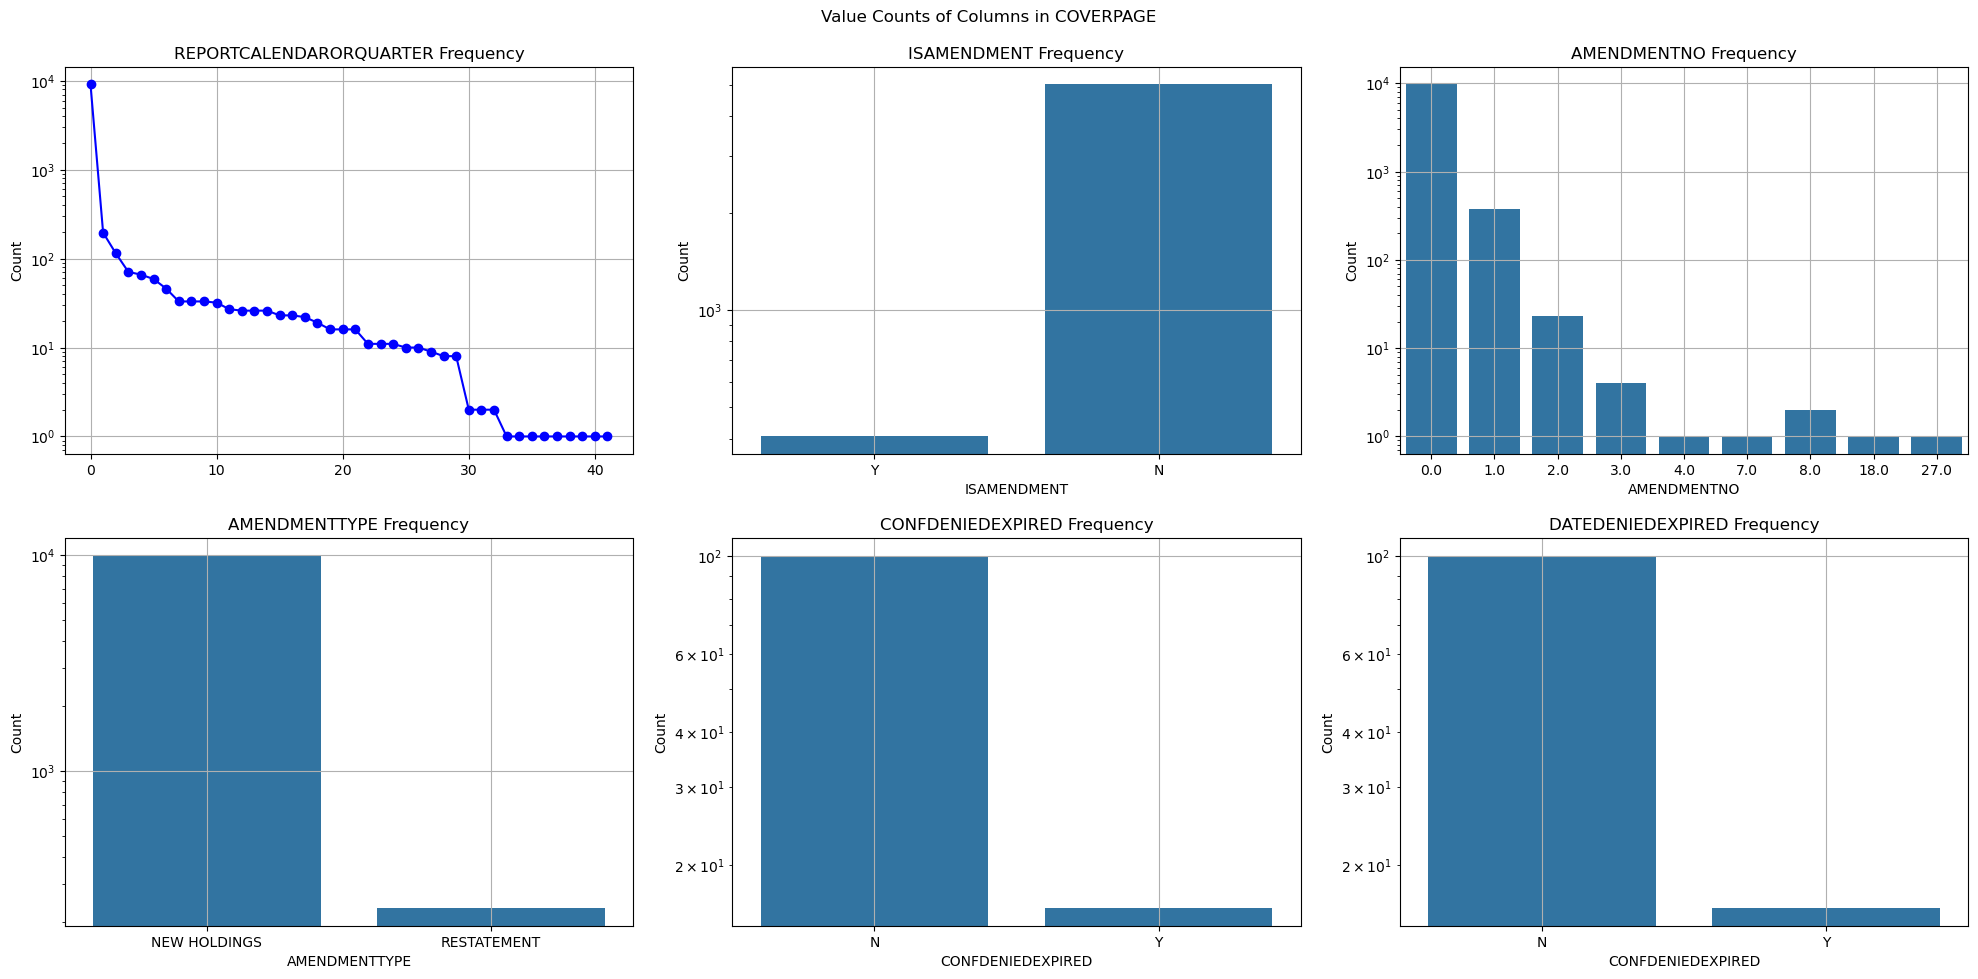

In [18]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))

ax[0,0].plot(df_cover['REPORTCALENDARORQUARTER'].value_counts().values, 
             color='blue', linestyle='-', marker='o')
ax[0,0].set_yscale('log')
ax[0,0].set_title("REPORTCALENDARORQUARTER Frequency")
ax[0,0].set_ylabel("Count")
ax[0,0].grid(True)

sns.countplot(data=df_cover, x='ISAMENDMENT', ax=ax[0,1])
ax[0,1].set_yscale('log')
ax[0,1].set_title("ISAMENDMENT Frequency")
ax[0,1].set_ylabel("Count")
ax[0,1].grid(True)

sns.countplot(data=df_cover, x='AMENDMENTNO', ax=ax[0,2])
ax[0,2].set_yscale('log')
ax[0,2].set_title("AMENDMENTNO Frequency")
ax[0,2].grid(True)
ax[0,2].set_ylabel("Count")

sns.countplot(data=df_cover, x='AMENDMENTTYPE', ax=ax[1,0])
ax[1,0].set_yscale('log')
ax[1,0].set_title("AMENDMENTTYPE Frequency")
ax[1,0].set_ylabel("Count")
ax[1,0].grid(True)

sns.countplot(data=df_cover, x='CONFDENIEDEXPIRED', ax=ax[1,1])
ax[1,1].set_yscale('log')
ax[1,1].set_title("CONFDENIEDEXPIRED Frequency")
ax[1,1].set_ylabel("Count")
ax[1,1].grid(True)

sns.countplot(data=df_cover, x='CONFDENIEDEXPIRED', ax=ax[1,2])
ax[1,2].set_yscale('log')
ax[1,2].set_title("DATEDENIEDEXPIRED Frequency")
ax[1,2].set_ylabel("Count")
ax[1,2].grid(True)

plt.suptitle("Value Counts of Columns in COVERPAGE")
plt.tight_layout(pad=1.5)
plt.show()

These plots help us understand the data distributions of each column in the table. However, these features are not necessarily guaranteed to be used for our modeling, but serve as exploratory data analysis. We notice there is quite a bit of imbalance within these columns, one reason we decided against using these variables when performing model building. We did not want to bias our models with one specific level of these variables versus another due to the high data imbalance within these features. We also didn't think these variables would be as useful in actually predicting the total value of assets/securities held overall.

## <a id='toc1_7_'></a>[Summary Page EDA](#toc0_)

### <a id='toc1_7_1_'></a>[Summary](#toc0_)

In [19]:
print("Shape for Summarypage dataframe:")
print(df_summary.shape)

Shape for Summarypage dataframe:
(8244, 5)


In [20]:
print("Data types of the columns for Summarypage:")
print(df_summary.dtypes)

Data types of the columns for Summarypage:
ACCESSION_NUMBER              object
OTHERINCLUDEDMANAGERSCOUNT     int64
TABLEENTRYTOTAL                int64
TABLEVALUETOTAL                int64
ISCONFIDENTIALOMITTED         object
dtype: object


In [21]:
print("Descriptive statistics for numerical columns:")
print(df_summary.describe())

Descriptive statistics for numerical columns:
       OTHERINCLUDEDMANAGERSCOUNT  TABLEENTRYTOTAL  TABLEVALUETOTAL
count                 8244.000000      8244.000000     8.244000e+03
mean                     0.426371       792.687773     7.108208e+09
std                      2.111025     16643.253831     9.897344e+10
min                      0.000000         0.000000     0.000000e+00
25%                      0.000000        33.000000     1.368915e+08
50%                      0.000000        94.000000     3.001886e+08
75%                      0.000000       230.250000     9.427800e+08
max                     69.000000    992103.000000     5.205558e+12


There is a very wide range for `TABLEVALUETOTAL`, the total value of assets/securities held by an institution. This comes as no suprise, but we do find it interesting there were some 0 values here. This may be due to an institution not holding any securities at the time of the filing. There are some larger values though with companies having billions in securities value, so transforming this variable could be helpful in analysis seeing how skewed the data may be with potential outliers. A log transform and/or a standardization could help when model building for this variable seeing its wide range of values.

In [22]:
print("Descriptive statistics for categorical columns:")
print(df_summary.describe(include=['object']))

Descriptive statistics for categorical columns:
            ACCESSION_NUMBER ISCONFIDENTIALOMITTED
count                   8244                  5501
unique                  8244                     2
top     0002035951-24-000001                     N
freq                       1                  5387


The majority of `ISCONFIDENTIALOMITTED` values are N, meaning no information has been confidentially omitted. So, in the majority of cases no information has been omitted under a confidential treatment request.

In [23]:
print("Number of missing values in each column of the summary page:")
print(df_summary.isna().sum())

Number of missing values in each column of the summary page:
ACCESSION_NUMBER                 0
OTHERINCLUDEDMANAGERSCOUNT       0
TABLEENTRYTOTAL                  0
TABLEVALUETOTAL                  0
ISCONFIDENTIALOMITTED         2743
dtype: int64


The only column with missing values is `ISCONFIDENTIALOMITTED`. This column is a boolean column that indicates whether the data is confidential. If the value is missing, we can assume that the data is not confidential.

In [24]:
df_summary['ISCONFIDENTIALOMITTED'] = df_summary['ISCONFIDENTIALOMITTED'].fillna('N/A')

Remove rows from `db_info` that report "principal amount"

To keep analysis consistent, we are only looking at rows that report the number of shares as discussed previously.

In [25]:
df_info = df_info[df_info['SSHPRNAMTTYPE'] == 'SH']

Merge `df_summary` with `df_cover`

In [26]:
df_investor = df_cover.merge(df_summary, how='inner', on='ACCESSION_NUMBER')

Drop two rows whose values appear to be incorrect

For these rows, the number of shares (`SSHPRNAMT`) appears to be reported as an unreasonably high number whereas the `VALUE` appears to be unreasonably row. We will drop these rows. Two rows are negligible in the context of the entire dataset.

In [27]:
df_info = df_info[df_info['ACCESSION_NUMBER'] != '0001104659-24-089646']
df_info = df_info[df_info['ACCESSION_NUMBER'] != '0000894189-24-004736']

Ensure datatypes are correct

In [28]:
df_info['SSHPRNAMT'] = df_info['SSHPRNAMT'].astype(float)

Compute summary statistics for each institution (`ACCESSION_NUMBER`) in `df_info`.

In [29]:
s = df_info.groupby(by="ACCESSION_NUMBER")['VALUE'].mean()
s = s.rename("MEAN VALUE")
df_stats = s.to_frame()

Summary statistics for VALUE, the value of a security/asset.

In [30]:
df_stats['MIN VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].min()
df_stats['MAX VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].max()
df_stats['STD VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].std()
df_stats['25% VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].quantile(q = 0.25)
df_stats['50% VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].median()
df_stats['75% VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].quantile(q = 0.75)
df_stats['10% VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].quantile(q = 0.10)
df_stats['90% VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].quantile(q = 0.90)
df_stats['99% VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].quantile(q = 0.99)
df_stats['01% VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].quantile(q = 0.01)

Summary statistics for SSHPRNAMT, but only take shares and not principal amount, hence why we name is SHAMT as we filered out the principal amount rows. We decided to use shares since the number of shares we saw as more important to determine the value of securities, since these represent stocks in a company.

In [31]:
df_stats['MEAN SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].mean()
df_stats['MIN SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].min()
df_stats['MAX SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].max()
df_stats['STD SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].std()
df_stats['25% SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].quantile(q = 0.25)
df_stats['50% SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].median()
df_stats['75% SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].quantile(q = 0.75)
df_stats['10% SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].quantile(q = 0.10)
df_stats['90% SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].quantile(q = 0.90)
df_stats['99% SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].quantile(q = 0.99)
df_stats['01% SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].quantile(q = 0.01)

In [32]:
df_stats = df_stats.reset_index()

Add feature for US vs. non-US institutions

In [33]:
state_df = pd.read_csv("../data/state_list.csv")
state_set = set(list(state_df['Abbreviation']))
def UnitedStatesIndicator(x):
    # check if the location is in the US based on the state abbreviation
    return (x in state_set) 
df_investor['US_Indicator'] = df_investor['FILINGMANAGER_STATEORCOUNTRY'].apply(UnitedStatesIndicator)

Get full country/state name

In [34]:
# Initialize an empty dictionary
state_dict = {}
# Open the CSV file
with open('../data/state_country_abbreviations.csv', mode='r') as file:
    reader = csv.reader(file,skipinitialspace = True)
    # Iterate through the rows in the file
    for row in reader:
        # Assign the first column as the key and the second column as the value
        state_dict[row[0]] = row[1]
        
def get_country_state(x):
    try: return state_dict[x]
    except KeyError: return np.nan
    
df_investor['State_Country_Full'] = df_investor['FILINGMANAGER_STATEORCOUNTRY'].apply(get_country_state)

Import US State GDP data

Additionally, we will add a column that indicates whther the institution is located in the United States.

In [35]:
df_state_gdp = pd.read_csv("../data/state-gdp.csv")
df_state_gdp.columns.values

array(['State', 'Abbreviation', 'Region', '2022_MM', '2023_MM',
       '2023_Q4_Seasonally_Adjusted_MM', '2024_Q1_Seasonall_Adjusted_MM',
       '2024_Q2_Seasonall_Adjusted_MM',
       '2023_Percent_Change_From_Preceding_Period',
       '2024_Q1_Percent_Change_From_Preceding_Period',
       '2024_Q2_Percent_Change_From_Preceding_Period'], dtype=object)

In [36]:
df_ = df_investor['FILINGMANAGER_STATEORCOUNTRY'].value_counts().to_frame().reset_index()

df_state_gdp =df_state_gdp.merge(right=df_, how='inner',left_on = 'Abbreviation',right_on='FILINGMANAGER_STATEORCOUNTRY')

df_us = df_investor[df_investor['US_Indicator'] == True]

df_us2 = df_us.merge(
    right=df_state_gdp, 
    how='inner', 
    left_on = 'FILINGMANAGER_STATEORCOUNTRY', 
    right_on='Abbreviation')

Merge `df_stats` with `df_us2`

In [37]:
df_us2 = df_us2.merge(right=df_stats, how='inner',on='ACCESSION_NUMBER')

Get investor city

In [38]:
df_us2['FILINGMANAGER_CITY'] = df_us2['FILINGMANAGER_CITY'].str.lower()

In [39]:
df_us2['FILINGMANAGER_CITY'].value_counts()

FILINGMANAGER_CITY
new york              824
boston                192
chicago               179
san francisco         157
houston               109
                     ... 
sante fe                1
saint paul              1
indian rocks beach      1
kokomo                  1
kerrville               1
Name: count, Length: 1276, dtype: int64

New York seems to be the most frequent city associated with the filing manager in the dataset. The top 5 cities are rather large cities which comes as no suprise.

Choose features

In [40]:
features = [
    'TABLEENTRYTOTAL',
    'TABLEVALUETOTAL',
    '2024_Q2_Seasonall_Adjusted_MM',
    '2024_Q2_Percent_Change_From_Preceding_Period',
    'MIN VALUE',
    'MAX VALUE',
    'MEAN VALUE',
    'STD VALUE',
    '25% VALUE',
    '50% VALUE',
    '75% VALUE',
    '01% VALUE',
    '99% VALUE',
    '10% VALUE',
    '90% VALUE',
    'MIN SHAMT',
    'MAX SHAMT',
    'MEAN SHAMT',
    'STD SHAMT',
    '25% SHAMT',
    '50% SHAMT',
    '75% SHAMT',
    '01% SHAMT',
    '99% SHAMT',
    '10% SHAMT',
    '90% SHAMT',
]

We get the log of the variables to observe if there is any correlation or trends with these features and our target variable.

In [41]:
def get_log_feature(x):
    try: return np.log(x)
    except RuntimeWarning: return 0

In [42]:
log_features = [
    'LOG TABLEENTRYTOTAL',
    'LOG TABLEVALUETOTAL',
    'LOG 2024_Q2_Seasonall_Adjusted_MM',
    'LOG 2024_Q2_Percent_Change_From_Preceding_Period',
    'LOG MIN VALUE',
    'LOG MAX VALUE',
    'LOG MEAN VALUE',
    'LOG STD VALUE',
    'LOG 25% VALUE',
    'LOG 50% VALUE',
    'LOG 75% VALUE',
    'LOG 01% VALUE',
    'LOG 99% VALUE',
    'LOG 10% VALUE',
    'LOG 90% VALUE',
    'LOG MIN SHAMT',
    'LOG MAX SHAMT',
    'LOG MEAN SHAMT',
    'LOG STD SHAMT',
    'LOG 25% SHAMT',
    'LOG 50% SHAMT',
    'LOG 75% SHAMT',
    'LOG 01% SHAMT',
    'LOG 99% SHAMT',
    'LOG 10% SHAMT',
    'LOG 90% SHAMT',
]

In [43]:
for i, log_feature in enumerate(log_features):
    df_us2[log_feature] = df_us2[features[i]].apply(get_log_feature)
feature_list = log_features
feature_list.append('OTHERINCLUDEDMANAGERSCOUNT')
df_starlog = df_us2[log_features]
df_star = df_us2[features]
df_star.to_csv("df_star.csv")

We now make a plot for average value of securities held by institution:


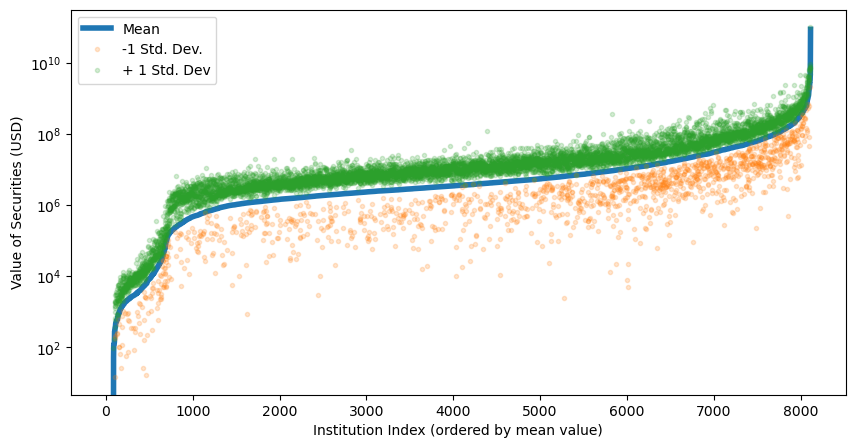

In [44]:
df_stats_sorted = df_stats.sort_values(by="MEAN VALUE")
x = np.arange(len(df_stats_sorted))
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(x, df_stats_sorted['MEAN VALUE'], label='Mean',linewidth=4)
ax.plot(x, df_stats_sorted['MEAN VALUE'] - df_stats_sorted['STD VALUE'],'.', alpha=0.2,label='-1 Std. Dev.')
ax.plot(x, df_stats_sorted['MEAN VALUE'] + df_stats_sorted['STD VALUE'],'.', alpha=0.2, label='+ 1 Std. Dev')
ax.set_ylabel("Value of Securities (USD)")
ax.legend()
ax.set_xlabel("Institution Index (ordered by mean value)")
ax.set_yscale("log")

Each institutional investor holds a porfolio of securities that are reported on Form 13F. Each security is held in given quantity at a given value. We compute the average value of securities held by each institution. Note that on Form 13F, the total value of the securities is reported, not the price of one share. It seems there is a very wide range of values held by intitutions based on this analysis, with many towards the middle of the plot around the same value.

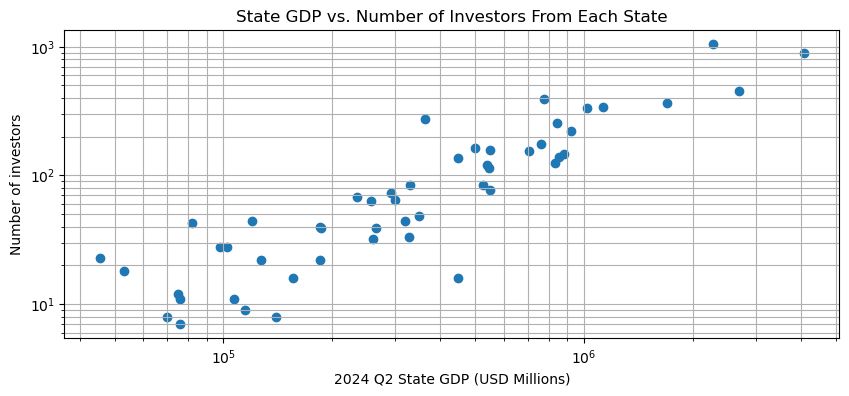

In [45]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.scatter(df_state_gdp['2024_Q2_Seasonall_Adjusted_MM'], df_state_gdp['count'])
ax.set_xscale('log')
ax.set_xlabel("2024 Q2 State GDP (USD Millions)")
ax.set_ylabel("Number of investors")
ax.grid(True,which='both')
ax.set_yscale('log')
ax.set_title("State GDP vs. Number of Investors From Each State")
plt.show()

This next plot shows State GDP vs. Number of Investors per State.

Here, each data point represents an indvidual state. States with higher GDPs have more investors. This is not surprising as states with higher GDPs have more economic activity and thus more investors.

### <a id='toc1_7_2_'></a>[Numerical Correlations with `TOTAL_VALUE`](#toc0_)

Here we make many scatterplots comparing various features with `TABLEVALUETOTAL` and analyze it below these plots. We note that since there was so much skewing in `TABLEVALUETOTAL`, we had to use a log scale version to make the plots actually useful and readable. We also decided from this observation, taking the log of `TABLEVALUETOTAL` for model building could be helpful for analysis to prevent skewing. We also took the log transform of the numeric features (X-axis), since without the log transform there was still heavy skewing. This is because some investors have such a wide range values of securities with some large outliers, so not doing any transformations on these variables would harm overall analysis, hence both features are on a log scale. We note that from earlier analysis we observed that some values for `VALUE` or `TABLEVALUETOTAL` were 0, hence we decided to make these values 0.0001 to avoid using log(0).

#### <a id='toc1_7_2_1_'></a>[Correlating `TOTAL_VALUE` with the summary statistics of the `VALUE` column in `df_info`.](#toc0_)

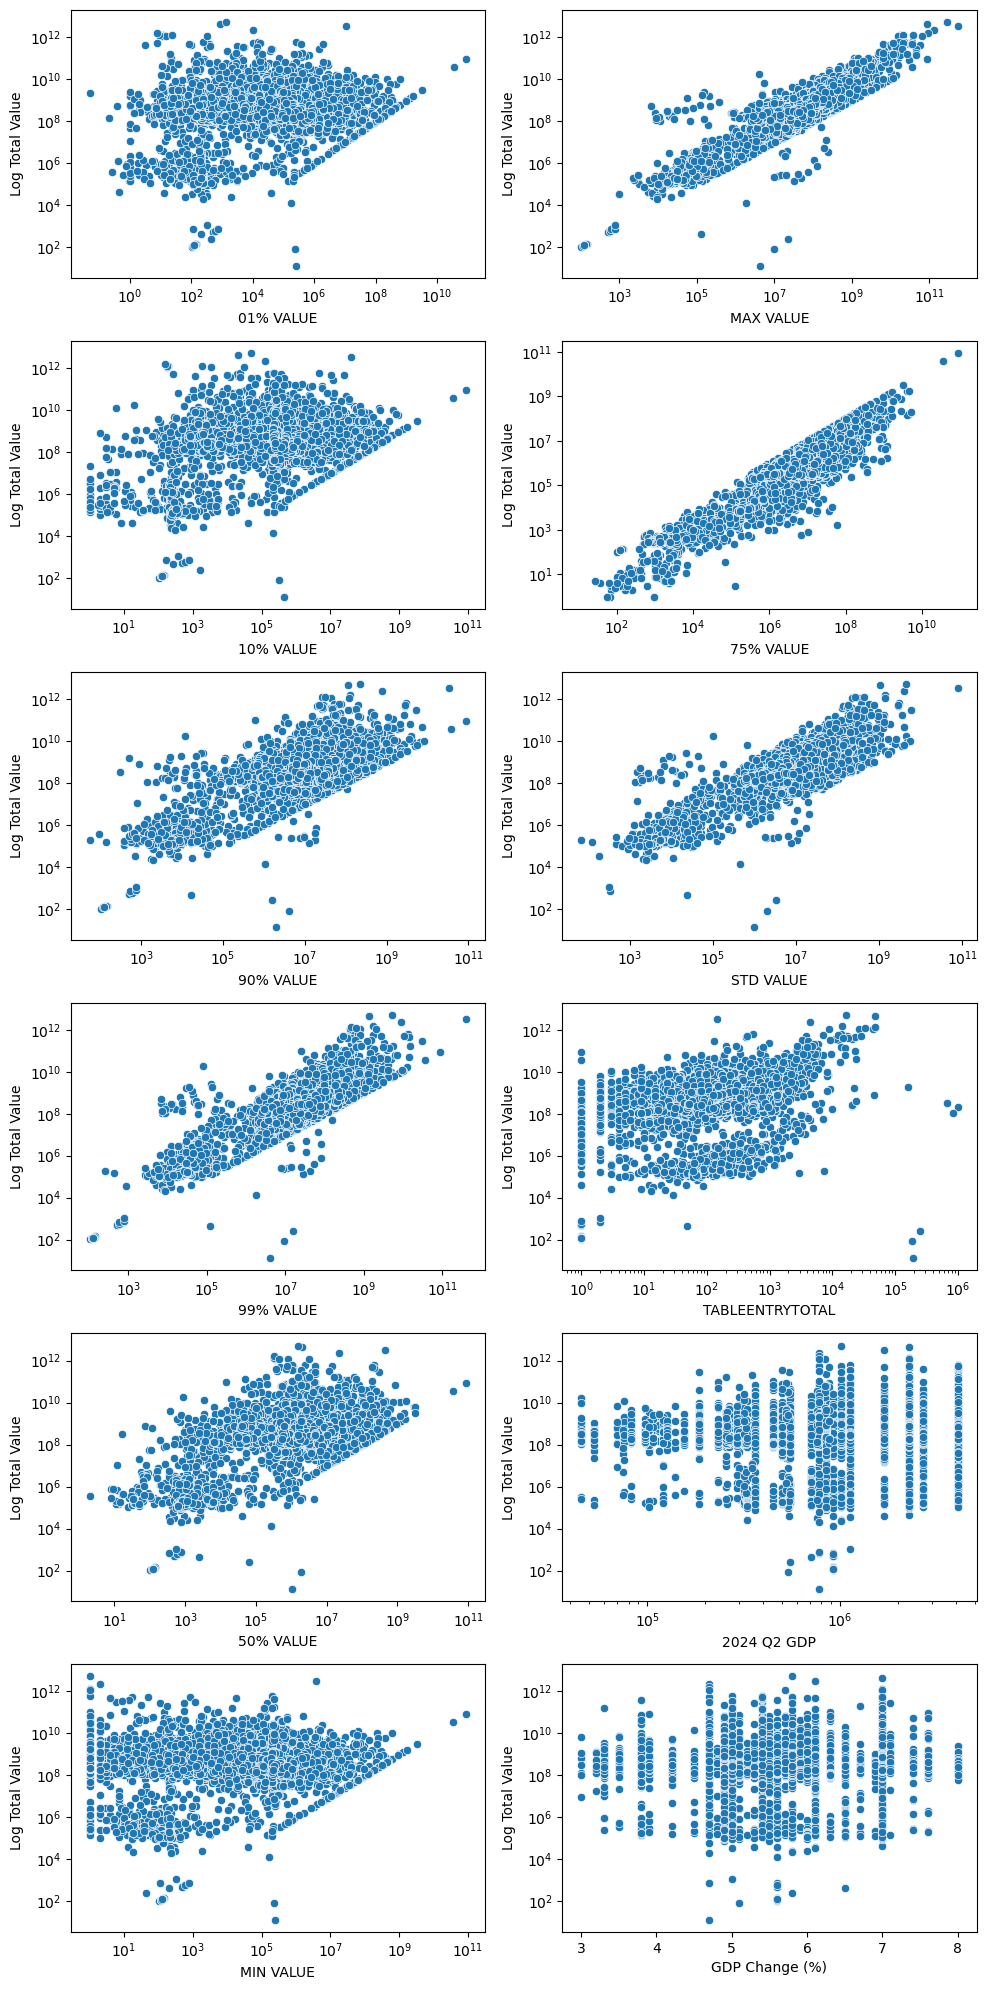

In [46]:
fig, ax = plt.subplots(6,2,figsize=(10,20))
a1 = ax[0,0]
a2 = ax[1,0]
a3 = ax[2,0]

a4 = ax[3,0]
a5 = ax[4,0]
a6 = ax[5,0]

a7 = ax[0,1]
a8 = ax[1,1]
a9 = ax[2,1]

a10 = ax[3,1]
a11 = ax[4,1]
a12 = ax[5,1]

# a1 = ax
sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '01% VALUE', ax = a1)
a1.set_xscale("log"), a1.set_yscale("log")
a1.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '10% VALUE', ax = a2)
a2.set_xscale("log"), a2.set_yscale("log")
a2.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '90% VALUE', ax = a3)
a3.set_xscale("log"), a3.set_yscale("log")
a3.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '99% VALUE', ax = a4)
a4.set_xscale("log"), a4.set_yscale("log")
a4.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '50% VALUE', ax = a5)
a5.set_xscale("log"), a5.set_yscale("log")
a5.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = 'MIN VALUE', ax = a6)
a6.set_xscale("log"), a6.set_yscale("log")
a6.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = 'MAX VALUE', ax = a7)
a7.set_xscale("log"), a7.set_yscale("log")
a7.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = '25% VALUE', x = '75% VALUE', ax = a8)
a8.set_xscale("log"), a8.set_yscale("log")
a8.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = 'STD VALUE', ax = a9)
a9.set_xscale("log"), a9.set_yscale("log")
a9.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, x = 'TABLEENTRYTOTAL', y = 'TABLEVALUETOTAL', ax = a10)
a10.set_xscale("log"), a10.set_yscale("log")
a10.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, x = '2024_Q2_Seasonall_Adjusted_MM', y = 'TABLEVALUETOTAL', ax = a11)
a11.set_xscale("log"), a11.set_yscale("log")
a11.set_xlabel("2024 Q2 GDP")
a11.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, x = '2024_Q2_Percent_Change_From_Preceding_Period', y = 'TABLEVALUETOTAL', ax = a12)
a12.set_xlabel("GDP Change (%)")
a12.set_ylabel("Log Total Value")
a12.set_yscale("log")
plt.tight_layout()
plt.show()

One quick observation we made was looking at the log transform, there is a much more clear linear relationship with some variables and Log total value. Without the log transform there was heavy skewing, so we decided that these visualizations can help us observe any trends with log Total value. As mentioned earlier, without the log transform there was significant skewing since more intitutions have a smaller value of securities/assets whereas some institutions have very large assets, and these visualizations wouldn't help much. Overall, we can see some of the distributional statistics such as the log of `MAX VALUE`, `75% VALUE`, and `STD VALUE` for example have a very strong linear relationship with log total value. This is interesting, as it could suggest these are strong predictors an institutions total value, especially when performing linear regression when linearity is needed. Variables such as the log of `Q2 GDP` and `GDP Change (%)` were not as strong, these variables wouldn't determine the total value of securities necessarily. We discuss this further below. We also note that variables such as `MAX VALUE` and `75% VALUE` could be strongly correlated, since one represents the max security value an intitution holds and the other the 75th percentile of the distribution of security values they hold.

#### <a id='toc1_7_2_2_'></a>[Correlating `TOTAL_VALUE` with the summary statistics of the `SSHPRNAMT` column in `df_info`.](#toc0_)

We make scatterplots again with both variables log transformed. We note we only use share amounts from `SSHPRNAMT` as discussed previously.

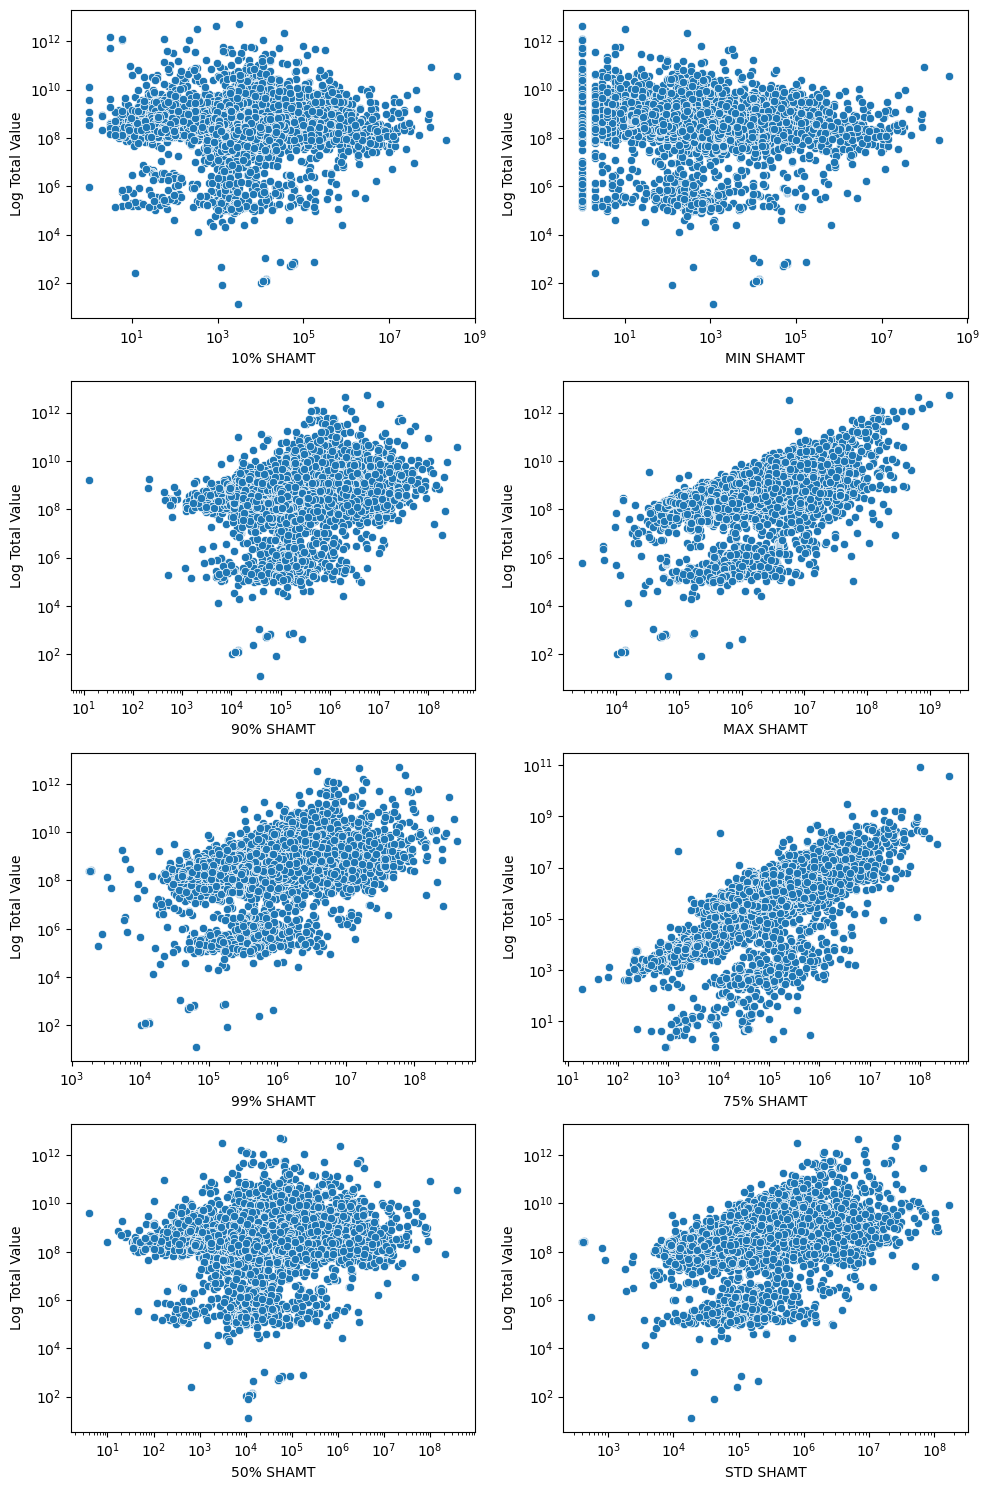

In [47]:
# fig, ax = plt.subplots(1,1,figsize=(6,3))
fig, ax = plt.subplots(4,2,figsize=(10,15))

a2 = ax[0,0]
a3 = ax[1,0]
a4 = ax[2,0]
a5 = ax[3,0]

a6 = ax[0,1]
a7 = ax[1,1]
a8 = ax[2,1]
a9 = ax[3,1]

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '10% SHAMT', ax = a2)
a2.set_xscale("log"), a2.set_yscale("log")
a2.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '90% SHAMT', ax = a3)
a3.set_xscale("log"), a3.set_yscale("log")
a3.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '99% SHAMT', ax = a4)
a4.set_xscale("log"), a4.set_yscale("log")
a4.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '50% SHAMT', ax = a5)
a5.set_xscale("log"), a5.set_yscale("log")
a5.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = 'MIN SHAMT', ax = a6)
a6.set_xscale("log"), a6.set_yscale("log")
a6.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = 'MAX SHAMT', ax = a7)
a7.set_xscale("log"), a7.set_yscale("log")
a7.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = '25% VALUE', x = '75% SHAMT', ax = a8)
a8.set_xscale("log"), a8.set_yscale("log")
a8.set_ylabel("Log Total Value")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = 'STD SHAMT', ax = a9)
a9.set_xscale("log"), a9.set_yscale("log")
a9.set_ylabel("Log Total Value")

plt.tight_layout()
plt.show()

We can see there is not much correlation in these scatterplots, as potentially `SHAMT`, many not be as relevant. Though, we do notice the log of `MAX SHAMT` and `STD SHAMT` may have some sort of positive correlation with log total value, which we found interesting and could be useful in model building.

In [48]:
df_starlog1 = df_starlog[[
    'LOG TABLEVALUETOTAL',
    'LOG MIN SHAMT',
    'LOG MAX SHAMT',
    'LOG MEAN SHAMT',
    'LOG STD SHAMT',
    'LOG 25% SHAMT',
    'LOG 50% SHAMT',
    'LOG 75% SHAMT',
    'LOG 01% SHAMT',
    'LOG 99% SHAMT',
    'LOG 10% SHAMT',
    'LOG 90% SHAMT']]

df_starlog2 = df_starlog[[
    'LOG TABLEVALUETOTAL',
    'LOG MIN VALUE',
    'LOG MAX VALUE',
    'LOG MEAN VALUE',
    'LOG STD VALUE',
    'LOG 25% VALUE',
    'LOG 50% VALUE',
    'LOG 75% VALUE',
    'LOG 01% VALUE',
    'LOG 99% VALUE',
    'LOG 10% VALUE',
    'LOG 90% VALUE',
]]
corr =  df_starlog2.corr()

#### <a id='toc1_7_2_3_'></a>[Heatmap of correlations with logathmically transformed features.](#toc0_)

We make a heatmap of the log transformed features and their relationship with each other.

<Axes: >

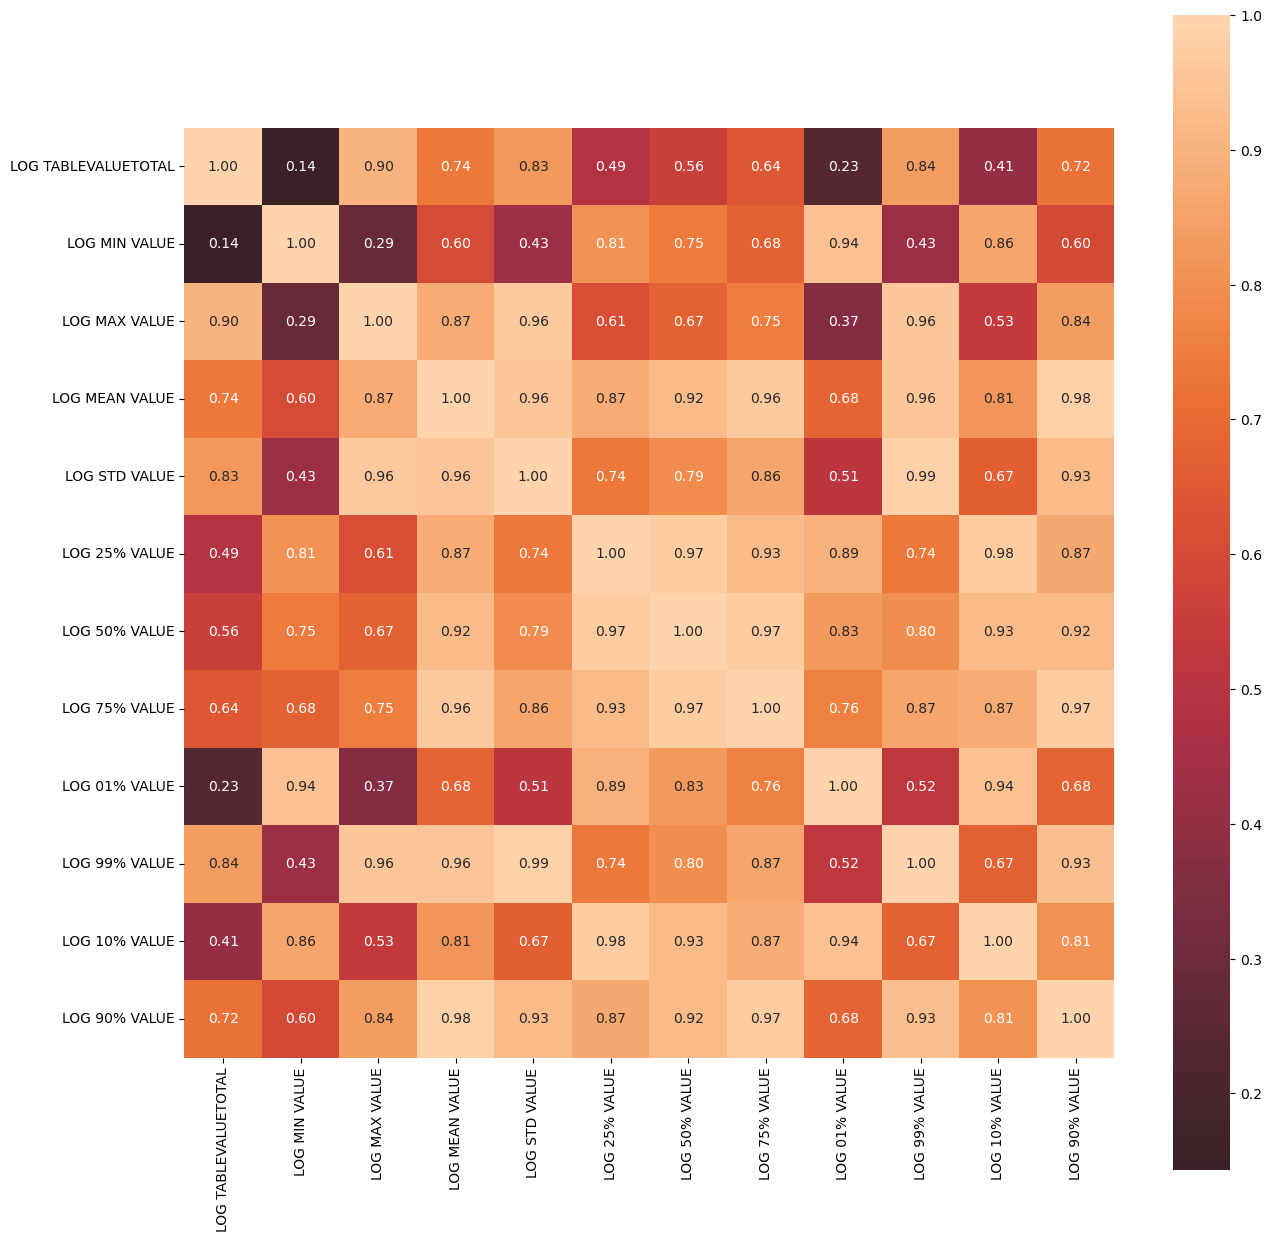

In [49]:

plt.figure(figsize=(15, 15))
sns.heatmap(corr, center=0, annot=True,fmt='.2f', square=True)

#### <a id='toc1_7_2_4_'></a>[Key Correlations Observed](#toc0_)
- **VALUE Summary Statistics**: These metrics capture the distribution of individual security values, reflecting an investor's overall portfolio structure. Including features like `LOG MEAN VALUE` and `LOG MAX VALUE` helps the model capture the central tendency and extreme holdings of securities.
- **SSHPRNAMT Summary Statistics**: Positive correlations were also observed between the summary statistics of `SHAMT` (e.g., standard deviation, percentiles) and the target. Features like `LOG STD SHAMT` and `LOG MAX SHAMT` quantify the diversity in share amounts held, indicating an investor's risk profile and strategy. Higher variance or extreme values in shares held often correspond to larger portfolios, making these features predictive.
- **State GDP**: A significant correlation between state GDP and the number of investors in each state was noted. Higher state GDP implies a concentration of large institutional investors. Including state-level GDP as a predictor (`2024 Q2 GDP`) helps account for geographic economic influence on portfolio size.

#### <a id='toc1_7_2_5_'></a>[Heatmap Insights for Feature Selection](#toc0_)
- The heatmap depicted correlations between `TABLEVALUETOTAL` and the summary statistics of `VALUE` and `SSHPRNAMT`. High correlations for `LOG MAX VALUE`, `LOG MEAN VALUE`, and `LOG STD VALUE` indicate their predictive strength. Similarly, `LOG MAX SHAMT` and `LOG STD SHAMT` are strong predictors due to their correlation with `TABLEVALUETOTAL`. The heatmap aids in identifying features that contribute the most to the variability in the target variable. Features with weak correlations can be excluded, reducing model complexity without losing predictive power.

#### <a id='toc1_7_2_6_'></a>[Findings from Scatter Plots](#toc0_)
- Scatter plots of summary statistics (percentiles, mean, and max) against `TABLEVALUETOTAL` highlighted:
  - Linear relationships post-log transformation, potentially justifying the choice of log-transformed features in the model.
  - Outliers in certain investors’ data, which may require handling (e.g., removal or robust regression methods).
  - Scatter plots validate the appropriateness of features by visually confirming their relationship with the target variable.
  - These plots guide feature engineering, such as applying transformations (e.g., logarithm) or considering interaction terms (e.g., combining `VALUE` and `SSHPRNAMT`).


#### <a id='toc1_7_2_7_'></a>[Geographic Insights](#toc0_)
- The correlation between state GDP and the number of investors provides an additional dimension for modeling, connecting regional economic indicators with institutional asset values. This feature could capture macroeconomic trends influencing the portfolio sizes of investors from different regions.

## <a id='toc1_8_'></a>[Summary](#toc0_)
The findings from the correlations and visualizations assist in selecting final predictors that are both meaningful and correlated with the target variable, `TABLEVALUETOTAL`. It justifies the use of log transformations to linearize relationships and improve model interpretability, which we will use. This enhances the model’s performance by incorporating features derived from meaningful summary statistics and macroeconomic variables. Future iterations can explore interactions between these predictors or use feature importance metrics from advanced models to further refine the selection.

In the next section, we will use the following six predictors and performed a log transform, as well as scaled them. We decided to log transform due to the relationship we saw in the heatmap above and scatterplots, observing the linear relationship with log `TABLEVALUETOTAL`. We decided to also use standard scalar (standardization) since it actually seemed to improve results, even though we understand that for tree based models scaling is not needed, but it did help in regression slightly. (NOTE: In the video we made we were not able to say all of this in the 6 minutes of alloted time, hence mentioned to look in the notebook for full description of methods):
- `MAX SHAMT`
- `STD SHAMT`
- `STD VALUE`
- `MEAN VALUE`
- `MAX VALUE`
- `MIN VALUE`

We chose these predictors for multiple reasons, one of these reasons and potentially the most influencing being outside knowledge. We understand that to predict the total value of securities held by an institution, the security that they hold with the largest value (`MAX VALUE`) and smallest value (`MIN VALUE`) would be very strong indicators. `MAX VALUE` would be a strong indicators of the institution's largest security, while the `MIN VALUE` reflects the smallest security value, capturing the range of security values held by these institutions. Furthermore, the mean value of the securities they hold (`MEAN VALUE`) and standard deviation (`STD VALUE`) would be good predictors to measure the mean and spread of the securities value they own, measuring the overall portfolio diversity. Furthermore, SHAMT describes the share amount of each security held by the institution. This would also be an important predictor as the number of shares or the total quantity of an security held significantly influences the total value of the institution's holdings. Larger share amounts, `MAX SHAMT`, would indicate the maximum number of shares an institution owns of a asset/security, which is directly tied to the total value of assets/securities. The standard deviation of the share amounts, `STD SHAMT`, indicates the volatility in the share amounts and could indicate how active the institution is in trading or shifting their position. Furthermore, we chose the minimum and maximum dollar values and share amounts, as opposed to various percentiles of them, because in practice the maximum and minimum dollar values are easier to find.

Our hope is that these variables, representing essentially the distribution of asset/security holdings and their market values will provide insights into the total market value of investors portfolios. By examining these features we can uncover patterns that may reveal how an institution's portfolio influences their reported table value. `MAX VALUE` for example could indicate the presence of larger, higher value positions could significantly impact the total market value of a portfolio. The `MEAN VALUE` and `STD VALUE` can provide a measurement of the diversity of a portfolio, maybe more diverse portfolios with higher standard deviations would be those with larger total market values. Share amounts would also be interesting, as the max number of shares held in a single asset/security could point to significant positions that highly contribute to the total value of the portfolio and standard deviation the variability in these holdings.

We also saw that scatter plots show that these variables have a linear relationship with the target variable (after taking their natural logarithm), but do note this is not the primary reason for choosing these variables. In model building we develop modeling using XGBoost and random forest, both of which can easily work with non-linear predictors, so this observation is primarily for the linear regression model. We made these visualizations to explore trends and see what influenced log `TABLEVALUETOTAL` after taking the log due to heavy skewness, which did help in this model building section. We end up taking the log of `TABLEVALUETOTAL` to build the final model so there was no heavy skewing in our target variable, which we worried would harm analysis. We also observed that actually scaling the predictor variables helped overall, especially the regression model since scaling doesn't necessarily help tree based models as they can handle non-scaled data as we mentioned earlier.

The scatter plot and heatmap show that the state GDP and GDP change have nearly 0 correlation with the target variable. Therefore, we will not include these features in our model. We also know from past knowledge that State GDP and GDP may not have a direct impact on specific securities and financial data held by an institution and may not be relevent in our model. 

We calculate the $R^2$ and MSE scores across all 4 models we will develop to examine their accuracies. We develop a linear regression model and decision tree model as 2 baseline models for comparison. Next, we developed a random forest model and an XGBoost model as more advanced models for better comparison.

For the tree based models, we also display and calculate the MDI of the 6 variables. We decided to use the MDI since even though we understand that features with a higher cardinality are preferred, these are all numeric variables with similar ranges. Hence, cardinality shouldn't be as big of an issue. We use the squared error as the splitting criteria for these tree based models, as we are predicting a numeric variable.

We also note that from now on in model building, `TABLEVALUETOTAL` will be log transformed after we process the data and all 6 features are log transformed and scaled, but we keep the variables names the same for simplicity.

## <a id='toc1_9_'></a>[Modeling](#toc0_)

Here we include an illustration/flow chart of our model building.

![Flowchart](./flowchart.png)

We began with the full dataset, then through EDA we performed feature selection and used transformations to create our final features. As stated, we used log transformation and standard scaling to create our features from the previous section. We also log transformed the target variable, `TABLEVALUETOTAL`. Next, we used a train/test split (80% train) to split the data for evaluation. The training data will train the model, while the test data evaluates/validates the models final performance based on the error metrics MSE and $R^2$

### <a id='toc1_9_1_'></a>[Dataset Assembly](#toc0_)

In [50]:
assemble_dataset().to_csv(f'{main_path}/encoded_data.csv', index=False)

### <a id='toc1_9_2_'></a>[Data Processing and Feature Engineering](#toc0_)

In [51]:
df = pd.read_csv("../data/2024q3/encoded_data.csv")
features = [x for x in df.columns.values if x != 'TABLEVALUETOTAL']
X = df[features]
y = df['TABLEVALUETOTAL']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=True)

# Process data, perform transformations and scaling. In utils.py.
print("Train/test split complete.")
X_train, X_test, y_train, y_test = process_dataset(X_train, X_test, y_train, y_test)

# Save to CSV files
X_train.to_csv("../data/2024q3/X_train.csv", index=False)
X_test.to_csv("../data/2024q3/X_test.csv", index=False)
y_train.to_csv("../data/2024q3/y_train.csv", index=False)
y_test.to_csv("../data/2024q3/y_test.csv", index=False)

Train/test split complete.


In [52]:
# Select a subset of features
feature_subset = [
    'MAX SHAMT','STD SHAMT','STD VALUE',
    'MEAN VALUE','MAX VALUE','MIN VALUE']
X_train = X_train[feature_subset]
X_test = X_test[feature_subset]

## <a id='toc1_10_'></a>[Linear Regression](#toc0_)

Here, linear regression is used as a baseline model. It's performance is worse than expected. Below, we will achieve improved performance using other types of models.

In [53]:
mean_score, std_score, coefficients, intercept, y_pred_train, y_pred_test = implement_linear_regression(
    X_train, y_train, X_test, y_test, k=5)

print(f"Mean R^2 score: {mean_score}")
print(f"Standard deviation of R^2 score: {std_score}")

# Evaluate on the training set using cross-validated predictions
train_r2, train_mse = get_performance_metrics(y_train, y_pred_train)
test_r2, test_mse = get_performance_metrics(y_test, y_pred_test)

print(f"Training R^2 score (cross-validated): {train_r2}")
print(f"Training MSE (cross-validated): {train_mse}")

print(f"Test MSE: {test_mse}")
print(f"Test R^2 score: {test_r2}")

linreg_train_mse = train_mse
linreg_test_mse = test_mse
linreg_train_r2 = train_r2
linreg_test_r2 = test_r2

Mean R^2 score: 0.47052181472830235
Standard deviation of R^2 score: 0.03231436028056438
Training R^2 score (cross-validated): 0.4744153033075763
Training MSE (cross-validated): 13.627429189297334
Test MSE: 13.6329285958086
Test R^2 score: 0.5092669144819896


We can see the scores on the linear regression model are poor overall. The test $R^2$ score is very low, where only 50\% of the variability in the total value of securities is accounted for in this model. The test MSE is also relatively high.

## <a id='toc1_11_'></a>[Decision Tree](#toc0_)

The decision tree here is implemented as a second baseline model. We used a maximum depth of 10 and a minimum samples split of 2. All other parameters were left as default. Later, we will achieve better results with random forest and XGBoost.

The code for this is in util.py.

In [54]:
mean_score, std_score, feature_importances_dt, y_pred_train, y_pred_test, model = implement_decision_tree(
        X_train, y_train, X_test, y_test, max_depth=10, min_samples_split=2, k=5
    )
    
print(f"Mean R^2 score: {mean_score}")
print(f"Standard deviation of R^2 score: {std_score}")

# Evaluate metrics
train_r2, train_mse = get_performance_metrics(y_train, y_pred_train)
test_r2, test_mse = get_performance_metrics(y_test, y_pred_test)

print(f"Training R^2 score: {train_r2}")
print(f"Training MSE: {train_mse}")
print(f"Test R^2 score: {test_r2}")
print(f"Test MSE: {test_mse}")

# Print feature importances
feature_names_dt = X_train.columns
importance_df_dt = pd.DataFrame({
    'feature': feature_names_dt,
    'importance': feature_importances_dt
}).sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(importance_df_dt)

dt_train_mse = train_mse
dt_test_mse = test_mse
dt_train_r2 = train_r2
dt_test_r2 = test_r2

Mean R^2 score: 0.8995877713823222
Standard deviation of R^2 score: 0.02493576723832265
Training R^2 score: 0.9454763687565761
Training MSE: 1.413695886864715
Test R^2 score: 0.8688606341703671
Test MSE: 3.6431487161046383

Feature Importances:
      feature  importance
4   MAX VALUE    0.517344
5   MIN VALUE    0.462333
1   STD SHAMT    0.007290
2   STD VALUE    0.006534
0   MAX SHAMT    0.006053
3  MEAN VALUE    0.000447


We analyze these values when comparing the results to the random forest and XGBoost model, alongside the other baseline linear regression model. We do note already though that the test $R^2$ and MSE are better compared to the linear regression model.

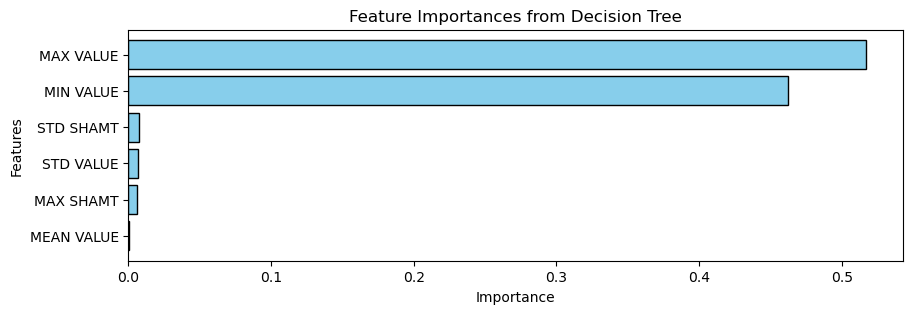

In [55]:
plt.figure(figsize=(10, 3))
plt.barh(importance_df_dt['feature'], importance_df_dt['importance'], color='skyblue', edgecolor='black')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Decision Tree')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

We can see that `MAX VALUE` and `MIN VALUE` are by far the most important features based on the decision tree models. The other 4 features have little influence, or no influence in the case of `MEAN VALUE`. We did find this slightly suprising, but then again the maximum and minimum value of assets held would be highly influential in predicting the total value of assets, whether or not it is on a log scale. It is suprising they are overpowering the other predictors though, we hypothesize this may be because the tree is simply just splitting on the highest and lowest value to predict the total value of assets since these 2 features are direct indicators of the total value itself.

## <a id='toc1_12_'></a>[Random Forest](#toc0_)

We decided to utilize `GridSearchCV` to find the optimal parameters based on the parameter grid we specified. We gave the grid search many options so we could discover the best combination of parameters. For max features, we used the default square root argument that we learned in class. For the number of estimators, `n_estimators`, we gave the model 3 options, 100, 200, and 300, to see if more trees would improve the model. Above 300 trees, the model performance did not necessarily improve, but computational costs increased. For the `max_depth`, we gave the model a wide range of values to experiment with different depths (5, 10, and 20), to see if shallow or deep trees performed better. For the minimum samples per leaf (`min_samples_leaf`), we gave the model a range of values to see how it could affect model performance. For minimum sample split (`min_samples_split`), we gave a smaller value (such as 2) to allow the tree to grow further, but also tested larger values (5 and 10), which prevent the tree from growing too deep.

The code for this is in util.py. We note that we used RandomForestRegressor from sklearn.ensemble, using KFold to split the data into folds when performing cross validation (GridSearchCV).

In [56]:
rf_results = implement_random_forest_with_grid_search(X_train, y_train, X_test, y_test, param_grid=None, k=5)

grid_search_best_score_rf,grid_search_cv_results_rf,best_model_rf_feature_importances,y_pred_train,y_pred_test,best_model_rf = rf_results

Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validated R^2 score: 0.9270570956829556


We see the best parameters found above. It is interesting that the largest depth option was 20, which was chosen in this model, so deeper trees may be prefered. Furthermore the optimal number of estimators was found to be 100, so the smallest option. We know that for bagging methods more trees may not always improve results, so potentially the random forest model did not improve with more trees in this approach. We also note in the ISLR book they stated that 100 trees is usually enough for these models, which we found here as well.

In [57]:
print(f"Mean R^2 score: {mean_score}")
print(f"Standard deviation of R^2 score: {std_score}")

# Evaluate metrics
train_r2, train_mse = get_performance_metrics(y_train, y_pred_train)
test_r2, test_mse = get_performance_metrics(y_test, y_pred_test)

print(f"Training R^2 score: {train_r2}")
print(f"Training MSE: {train_mse}")
print(f"Test R^2 score: {test_r2}")
print(f"Test MSE: {test_mse}")

# Print feature importances
feature_names_rf = X_train.columns
importance_df_rf = pd.DataFrame({
    'feature': feature_names_rf,
    'importance': best_model_rf_feature_importances
}).sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(importance_df_rf)

rf_train_mse = train_mse
rf_test_mse = test_mse
rf_train_r2 = train_r2
rf_test_r2 = test_r2

Mean R^2 score: 0.8995877713823222
Standard deviation of R^2 score: 0.02493576723832265
Training R^2 score: 0.9552601660908818
Training MSE: 1.1600203019119228
Test R^2 score: 0.9000209881506436
Test MSE: 2.777491002431615

Feature Importances:
      feature  importance
4   MAX VALUE    0.493722
5   MIN VALUE    0.459902
3  MEAN VALUE    0.022549
0   MAX SHAMT    0.010360
2   STD VALUE    0.007626
1   STD SHAMT    0.005841


We observe the error metrics for the random forest model above, alongside the feature importances which we will plot next. As for the errors, we can already see that the $R^2$ and MSE on the test data was better for this model compared to the 2 baseline models, which we discuss more in the following sections.

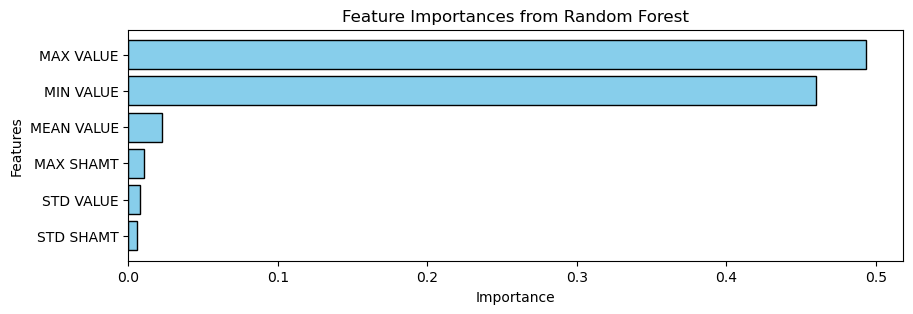

In [58]:
plt.figure(figsize=(10, 3))
plt.barh(importance_df_rf['feature'], importance_df_rf['importance'], color='skyblue', edgecolor='black')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

This feature importance plot is very similar to the decision tree, with `MAX VALUE` and `MIN VALUE` the 2 most important predictors. One detail we noticed is now `MEAN VALUE` is seen as slightly more important, where it wasn't important at all in the decision tree model. This has to be due to the subset selected at each node of predictors to split on, as the random forest allows different predictors to be used on a split with this key feature based on the square root argument of number of features to select at each node. At every node there would be a different subset the node could split on, hence why there is more importance for different predictors. Though, some nodes would probably have the same options eventually, but every node picks features at random. The two least important features were the standard deviation features, for security value and share amount. This is somewhat suprising, as potentially the diversity of a portfolio isn't as important as we had thought.

## <a id='toc1_13_'></a>[XGBoost](#toc0_)

For the XGBoost model we experiment with several different features to use in the `GridSearch`. First, we set the `n_estimators` argument and give it 5 possible values, 100, 200, 300, 500, and 700. This parameter will control the number of trees produced in the model. More trees could cause overfitting and allow the model to learn more complex patterns in the data, so we limited the number of trees instead of using too many. However, one could consider values such as 500 or 700 a lot, but with lower learning rates a greater number of trees would be necessary. We do note when describing the regularization parameters that these can help prevent overfitting, hence why values like 700 could be used here.

The learning rate parameter we chose to be a set value rather than adaptive, but we select the learning rate based on cross validation. We understand that a lower learning rate makes it so that the model requires more trees to fully converge, but could be more precise and prevent overfitting. We didn't choose an extremely high learning rate since as we saw in class for other algorithms such as Gradient Boosting a higher learning rate could cause the algorithm to diverge which we would like to avoid.

As for max depth we decided to experiment with 2 values, 1 and 2. A max depth of 1 would essentially be training over stumps with 1 depth, similar to what we did in class. On the other hand, a max depth of 2 adds one more layer to this tree. We decided to use these 2 values and not go any higher since these Boosting algorithms work well with "weak-learners" meaning in our case trees of lower depths rather than overly large trees, since the smaller trees have higher bias and improve its accuracy overtime as more trees are added to the model.

We decided to use the same 4 parameters for both `alpha` and `lambda`, the regularization parameters. We used standard values for `alpha` and `lambda`.  This is a key difference compared to other Boosting algorithms, such as Gradient Boosting which doesn't use regularization. The alpha represents the L1 regularization term for Lasso, adding a penalty based on the absolute value of leaf weights, while the lambda is the L2 regularization term for Ridge, which adds a penalty based on the squared values of leaf weights. This regularization can help the overall model from overfitting, which is why we were not afraid to give a larger number of estimators at 700. Though, we do note overfitting can still happen, but it mitigates the risk.

We note in the README.md we included a description of XGBoost, since this content was not covered.

In [59]:
param_grid = {
    'n_estimators': [100, 200, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [1, 2], 
    'alpha': [0, 0.001, 0.01, 0.1], 
    'lambda': [0, 0.001, 0.01, 0.1]     
}


We now create the model using grid search and observe what the best parameters were. We use the evaluation metric as the RMSE to minimize. Here we want to point out we utilized the xgb (XGBoost) library to make the XGBoost model, where we also used KFold to split the data into folds when performing cross validation (GridSearchCV).

In [60]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Create the XGBoost regressor model
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=cv, 
                           verbose=0, 
                           n_jobs=-1, 
                           return_train_score=True)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'alpha': 0.1,
 'lambda': 0.01,
 'learning_rate': 0.2,
 'max_depth': 2,
 'n_estimators': 700}

We can see the optimal parameters above. The algorithm chose an alpha value of 0.1 and lambda value of 0.01, so we can see some regularization in our model. It also chose the largest learning rate and number of estimators/trees, which we were slightly suprised with. We do note however that with regularization the XGBoost model can prevent overfitting better than other boosting methods such as Gradient Boosting. So, we hypothesize that the XGBoost model chose these parameters due to the incorporation of regularization in the loss function, attempting to limit and prevent this overfitting even with a larger number of estimators. We also note that a max depth of 2 was used, so not stumps in our case. Though, a depth of 2 would still be considered a weak learner.

Next, we can split the training data into a train and validation set. We saw the optimal number of estimators found was 700, but potentially the actual validation MSE is found at a smaller number of estimators. To investigate this, we split the train data into this train/validation split (80% train) and use an evaluation set which is similar to the "staged_score" in AdaBoosting to calculate the train/validation RMSE at each estimator/tree.

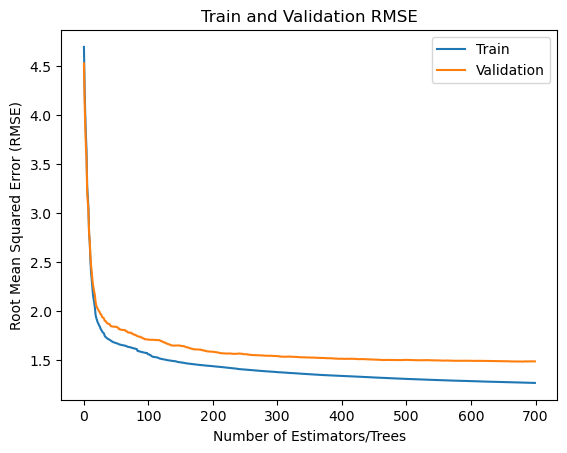

In [61]:
X_train80, X_val, y_train80, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

eval_set = [(X_train80, y_train80), (X_val, y_val)]

eval_results = grid_search.best_estimator_.fit(X_train80, y_train80, eval_set = eval_set, verbose=False)

eval_results = grid_search.best_estimator_.evals_result()

train_rmse = eval_results['validation_0']['rmse']
val_rmse = eval_results['validation_1']['rmse']

plt.plot(train_rmse, label='Train')
plt.plot(val_rmse, label='Validation')

plt.title('Train and Validation RMSE')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xlabel('Number of Estimators/Trees')
plt.legend()
plt.show()

Lowest validation RMSE:

In [62]:
ne = np.argmin(val_rmse)
print(ne)
s = f"""
We see the lowest validation RMSE was actually at {ne} estimators, so we can set this to be the new number of estimators alongside the other best parameters we found in grid search from earlier.
"""
md(s)

681



We see the lowest validation RMSE was actually at 681 estimators, so we can set this to be the new number of estimators alongside the other best parameters we found in grid search from earlier.


In [63]:
best_params = grid_search.best_params_
del best_params['n_estimators']
final_model_xgboost = xgb.XGBRegressor(**best_params, n_estimators = ne)
final_model_xgboost.fit(X_train, y_train)

y_pred = final_model_xgboost.predict(X_test)

test_mse = mean_squared_error(y_test, y_pred)  
test_r2 = r2_score(y_test, y_pred)
y_pred_train = final_model_xgboost.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

print(f"Mean Squared Error (MSE) on Training Data: {train_mse}")
print(f"Mean Squared Error (MSE) on Test Data: {test_mse}")
print(f"R-squared (R²) on Test Data: {test_r2}")
print(f"R-squared (R²) on Training Data: {train_r2}")

Mean Squared Error (MSE) on Training Data: 1.6870648542071036
Mean Squared Error (MSE) on Test Data: 2.78290461389602
R-squared (R²) on Test Data: 0.8998261189236061
R-squared (R²) on Training Data: 0.9349330341488563


We can see these results are pretty comparable with the test errors of the random forest model. The $R^2$ and MSE on the testing data is nearly the exact same.

In [64]:
xgboost_train_mse = train_mse
xgboost_test_mse = test_mse
xgboost_train_r2 = train_r2
xgboost_test_r2 = test_r2


Feature Importances:
      feature  importance
4   MAX VALUE    0.531766
5   MIN VALUE    0.301460
2   STD VALUE    0.079633
0   MAX SHAMT    0.054562
3  MEAN VALUE    0.025082
1   STD SHAMT    0.007496


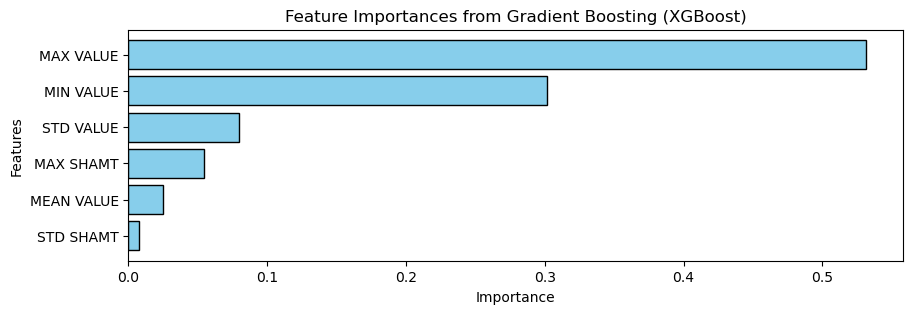

In [65]:
# Print feature importances
feature_importances_xgboost = final_model_xgboost.feature_importances_
feature_names = X_train.columns
importance_df_xgboost = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances_xgboost
}).sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(importance_df_xgboost)

plt.figure(figsize=(10, 3))
plt.barh(importance_df_xgboost['feature'], importance_df_xgboost['importance'], color='skyblue', edgecolor='black')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Gradient Boosting (XGBoost)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

It is interesting that the feature importance plot now shows that `MAX VALUE` is by far the most important feature, whereas `MIN VALUE` is not as important as it was in other models. It is interesting that `MIN VALUE` was seen as less important than the previous feature importance plots since it makes sense why `MIN VALUE` would be important, as it directly relates to the smallest value security held by institutions. The standard deviation of value and share amounts were not highly important, which could indicate again that the diversity of the portolfio is not as important as we once thought. Though, the standard deviation of `VALUE` was more important from this plot than previous plots, but the standard deviation of `SHAMT` was still seen as unimportant. Again, `MEAN VALUE` or `MAX SHAMT` just haven't been seen as very important

## <a id='toc1_14_'></a>[Comparison](#toc0_)

We now compare the error metrics for our 4 models.

In [66]:
from IPython.display import Markdown as md
cols = ['Model', 'Train R²', 'Test R²', 'Train MSE', 'Test MSE']
linreg_dict = {
    'Model': 'Linear Regression', 
    'Train R²': linreg_train_r2, 
    'Test R²': linreg_test_r2, 
    'Train MSE': linreg_train_mse, 
    'Test MSE': linreg_test_mse}

dt_dict = {
    'Model': 'Decision Tree', 
    'Train R²': dt_train_r2, 
    'Test R²': dt_test_r2, 
    'Train MSE': dt_train_mse, 
    'Test MSE': dt_test_mse}

rf_dict = {
    'Model': 'Random Forest',
    'Train R²': rf_train_r2,
    'Test R²': rf_test_r2,
    'Train MSE': rf_train_mse,
    'Test MSE': rf_test_mse
}

xgboost_dict = {
    'Model': 'XGBoost',
    'Train R²': xgboost_train_r2,
    'Test R²': xgboost_test_r2,
    'Train MSE': xgboost_train_mse,
    'Test MSE': xgboost_test_mse
}
data = [
    linreg_dict,
    dt_dict,
    rf_dict,
    xgboost_dict
]

comparison_df = pd.DataFrame(data, columns=cols)
md(comparison_df.to_markdown(index=False))

| Model             |   Train R² |   Test R² |   Train MSE |   Test MSE |
|:------------------|-----------:|----------:|------------:|-----------:|
| Linear Regression |   0.474415 |  0.509267 |    13.6274  |   13.6329  |
| Decision Tree     |   0.945476 |  0.868861 |     1.4137  |    3.64315 |
| Random Forest     |   0.95526  |  0.900021 |     1.16002 |    2.77749 |
| XGBoost           |   0.934933 |  0.899826 |     1.68706 |    2.7829  |

As expected, linear regression performed worse than all other models during both training and testing, in terms of both the mean squared error and the R² score. The decision tree model performed better than linear regression, but worse than random forest and XGBoost. Random forest and XGBoost performed similarly, but XGBoost had a slightly higher test mean squared error and a slightly lower R² score. This indicates the random forest model was slightly better than the XGBoost model, but not by much. Because random forest and XGBoost performed so similarly, we cannot conclusively say which model is better. However, XGBoost is generally considered to be a more powerful model than random forest, so we would choose XGBoost as our final model and potentially test more paramter combinations in future work.

We were wondering why XGBoost did not perform better than the random forest model. We hypothesize that the parameters we used for XGBoost may not have been adequate. In research, the websites we looked at all explained how much different XGBoost was from other Boosting techniques and its strengths, but many claimed the model requires careful parameter tuning with parameters such as the number of estimators, learning rate, and regularization parameters. While we believed our parameter combinations were sufficient, deeper exploration into more efficient parameter combinations could yield better results. One idea we had was potentially increasing the number of estimators, as XGBoost has built in regularization to prevent overfitting. We have learned other boosting methods such as Adaboost or Gradient Boosting can and will overfit with either a high learning rate, or too many trees/estimators. In contrast, XGBoost can still be overfit with a large number of trees or improper regularization terms, but the regularization helps to prevent overfitting. Exploring different regularization parameters combined with different number of estimators could yield better results for XGBoost in future work.

We also wonder if the learning rate parameter of 0.2 might have been too high. Possibly experimenting with smaller learning rate options could be useful, but our idea was that the reguarlization could've prevented the overfitting even with a higher learning rate. This may not be the case though, and could cause its slightly worse performance than random forests. With a smaller learning rate, we could also increase the number of estimators in the model overall so that the XGBoost model can converge to the optimal solution. We would then hope that with more estimators the regularization can help prevent overfitting.

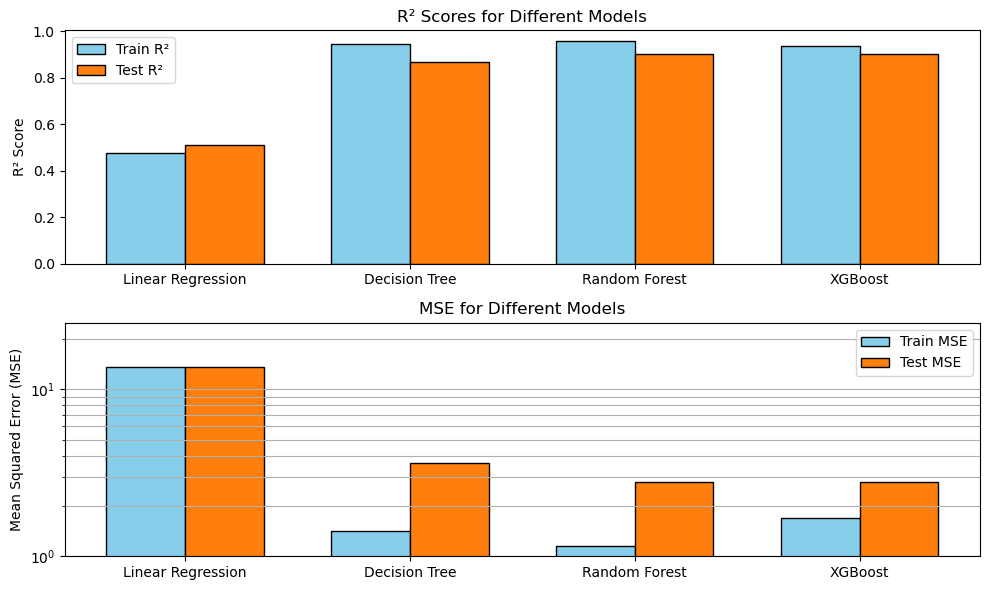

In [67]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
X = comparison_df['Model']
X_axis = np.arange(len(X))
bar_width = 0.35
ax[0].bar(X_axis, comparison_df['Train R²'], width = bar_width, color='skyblue', edgecolor='black', label="Train R²")
ax[0].bar(X_axis + bar_width, comparison_df['Test R²'], width = bar_width, color='tab:orange', edgecolor='black', label="Test R²")
ax[0].set_xticks(X_axis + bar_width / 2)
ax[0].set_xticklabels(X)
ax[0].legend()
ax[0].set_title("R² Scores for Different Models")
ax[0].set_ylabel("R² Score")

ax[1].grid(axis='y',which='both')
ax[1].bar(X_axis, comparison_df['Train MSE'], width = bar_width, color='skyblue', edgecolor='black', label="Train MSE")
ax[1].bar(X_axis + bar_width, comparison_df['Test MSE'], width = bar_width, color='tab:orange', edgecolor='black', label="Test MSE")
ax[1].set_xticks(X_axis + bar_width / 2)
ax[1].set_xticklabels(X)
ax[1].legend()
ax[1].set_title("MSE for Different Models")
ax[1].set_yscale('log')
ax[1].set_ylim(1e0, 2.5e1)
ax[1].set_ylabel("Mean Squared Error (MSE)")
plt.tight_layout()
plt.show()

Here are the plots for the $R^2$ and MSE scores across all models, but this time with bar plots. As we can see, the $R^2$ for linear regression was very poor on both the training and testing data. For the tree based algorithms the $R^2$ was much better and actually very comparable overall. There wasn't a significant difference in test $R^2$ between the tree models, but we do note that from earlier analysis Random Forest and XGBoost performed similarly. We just made this plot to make it easier to visualize, which we used on the presentation.

In terms of MSE, we again see that linear regression performed by far the worse with the highest test MSE. Decision tree performed better, but random forest and XGBoost were the best models. These are the same conclusions we made in the previous analysis table, but now visualized.

In [68]:
# rename importance column
importance_df_xgboost_ = importance_df_xgboost.rename(columns={'importance': 'importance_xgboost'})
importance_df_rf_ = importance_df_rf.rename(columns={'importance': 'importance_rf'})
importance_df_dt_ = importance_df_dt.rename(columns={'importance': 'importance_dt'})
importance_df_all = importance_df_xgboost_.merge(right = importance_df_rf_, how='left', on='feature')
importance_df_all = importance_df_all.merge(right = importance_df_dt_, how='left', on='feature')
importance_df_all

,feature,importance_xgboost,importance_rf,importance_dt
0,MAX VALUE,0.531766,0.493722,0.517344
1,MIN VALUE,0.301460,0.459902,0.462333
2,STD VALUE,0.079633,0.007626,0.006534
3,MAX SHAMT,0.054562,0.010360,0.006053
4,MEAN VALUE,0.025082,0.022549,0.000447
5,STD SHAMT,0.007496,0.005841,0.007290


Here are the feature importances across all 3 tree models, which we now visualize.

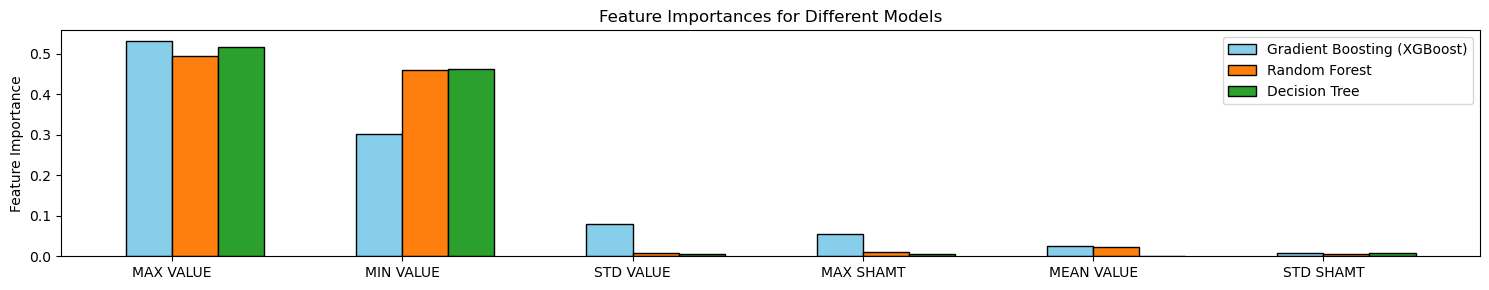

In [69]:

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
X = importance_df_all['feature']
X_axis = np.arange(len(X))
bar_width = 0.2
ax.bar(X_axis, importance_df_all['importance_xgboost'], width = bar_width, color='skyblue', edgecolor='black', label="Gradient Boosting (XGBoost)")
ax.bar(X_axis + bar_width, importance_df_all['importance_rf'], width = bar_width, color='tab:orange', edgecolor='black', label="Random Forest")
ax.bar(X_axis + 2*bar_width, importance_df_all['importance_dt'], width = bar_width, color='tab:green', edgecolor='black', label="Decision Tree")

ax.set_xticks(X_axis + bar_width / 2)
ax.set_xticklabels(X)
ax.legend()
ax.set_title("Feature Importances for Different Models")
ax.set_ylabel("Feature Importance")
plt.tight_layout()
plt.show()

For all models, the `MAX VALUE` is by far the most important predictor. `MIN VALUE` is the second most important predictor for all models. This makes sense, given that we are predicting the `TABLEVALUETOTAL`. The `MIN_VALUE` and `MAX_VALUES` put upper and lower bounds on the `TABLEVALUETOTAL`, hence why they are seen as so important in our models. The `STD VALUE` is the standard deviation of the dollar values of the individual securities held by each investors. This is the third most important predictor for the XGBoost, but it was not seen as important in the random forest or decision tree model. This was suprising, as the standard deviation of the dollar values of the individual securities held by each investor is a measure of the diversity of the investor's portfolio. We thought the diversity of their portfolio would be a strong indicator of the total value of securities held, but it surprisingly wasn't. 

`MAX SHAMT` and `STD SHAMT` were both not seen as highly important in the random forest or XGBoost model, which prompts questions into how useful these features are in predicting the total value of securities held by an institution. We thought that these share amount variables would be important as the number of shares of a security held by an institution and its variability would directly influence an institutions total holdings. Though, we do note that the max number of shares was slightly important in the XGBoost model, but not close to the top 2 features. `MEAN VALUE` not being as important could be due to the fact that the maximum and minimum security value could be more powerful and overpower this feature.

We hypothesize that XGBoost found the four weakest predictors to be more important than they were in random forest and the decision tree because of regularization in XGBoost. This regularization may have allowed predictors like `MAX SHAMT` or `STD VALUE` to be seen as more important in terms of impurity/information gain. The XGBoost model may not be overemphasizing the minimum value predictor as much as the other models, hence why the importance was smaller.

## <a id='toc1_15_'></a>[Conclusion](#toc0_)

The Form 13F dataset from the Securities and Exchange Commission was chosen because it is one of the few financial datasets that are free, open to the public, and trustworthy. The Form 13F data had many columns and tables, but most columns were not useful for prediction. It was challenging to find which columns were useful for prediction, and which were useful as the target variable. We needed to do a lot of data cleaning and feature engineering to get the data into a usable format (such as taking the log of the features and computing summary statistics). We used linear regression, decision tree, random forest, and XGBoost to predict the total value of assets held by institutional investors after taking the log scale of the target variable and features. There are perhaps many more questions that can be answered with this data using machine learning, such as predicting the number of shares held by an investor, or predicting the value of a specific security held by an investor. One aspect we did not explore was the individual securities held by each investor. We could have used the `CUSIP` to identify individual securities and predict the value of each security held by each investor.

From this project, we also learned the implementation for gradient boosting in XGBoost, which was not taught in class. By learning XGBoost, we took an additional step to discover a powerful prediction tool in predictive modeling. We also learned how parameter tuning is very important in models such as XGBoost or random forest, as selecting the correct predictors and parameters is essential to develop a strong model.

## <a id='toc1_16_'></a>[Appendix: Timeseries Modeling](#toc0_)

We also incorporates datasets from multiple years to build predictive models that account for temporal dependencies. Timeseries modeling was not covered in this course, but we tried it as an additional component of our project. Below are the results from the timeseries modeling.

In [70]:
if os.path.exists("infotable_dataset.csv"):
    infotable_dataset = pd.read_csv("infotable_dataset.csv", low_memory=False)
else:
    file_paths = [
        'INFOTABLE_2023q4.tsv',
        'INFOTABLE_2023q3.tsv'
    ]

    dataframes = []
    for file_path in file_paths:
        year_quarter = file_path.split('_')[1].split('.')[0]
        year = int(year_quarter[:4])
        quarter = int(year_quarter[4:].replace("q", ""))
        df = pd.read_csv(file_path, delimiter='\t', low_memory=False)
        df.rename(columns={'ACCESSION_NUMBER': 'investor'}, inplace=True)
        if quarter == 1:
            df['timestamp'] = pd.Timestamp(year, 1, 1)  # Q1: January 1st
        elif quarter == 2:
            df['timestamp'] = pd.Timestamp(year, 4, 1)  # Q2: April 1st
        elif quarter == 3:
            df['timestamp'] = pd.Timestamp(year, 7, 1)  # Q3: July 1st
        elif quarter == 4:
            df['timestamp'] = pd.Timestamp(year, 10, 1)  # Q4: October 1st

        dataframes.append(df)
        

    infotable_dataset = pd.concat(dataframes, ignore_index=True)

    infotable_dataset.to_csv("infotable_dataset.csv", index=False)

### <a id='toc1_16_1_'></a>[Scaling Without Time Series Cross-Validation](#toc0_)

Since we currently only have data for one quarter, there is no temporal pattern or chronological dependency to consider. This allows us to perform **Standardization** (Z-score scaling) across the entire dataset for this quarter without introducing bias from future data. Standardization transforms each feature to have a mean of 0 and a standard deviation of 1, making the scale of all features comparable.

In [71]:
numeric_features = ['VALUE', 'SSHPRNAMT', 'VOTING_AUTH_SOLE', 'VOTING_AUTH_SHARED', 'VOTING_AUTH_NONE']

scaler = StandardScaler()

infotable_dataset_standardized = infotable_dataset.copy()
infotable_dataset_standardized[numeric_features] = scaler.fit_transform(infotable_dataset[numeric_features])

print(infotable_dataset_standardized[numeric_features].head())

      VALUE  SSHPRNAMT  VOTING_AUTH_SOLE  VOTING_AUTH_SHARED  VOTING_AUTH_NONE
0 -0.038142  -0.032628         -0.026317           -0.025341         -0.015885
1  0.099572   0.004316          0.018649           -0.025341         -0.012671
2 -0.021993  -0.032612         -0.026398           -0.025341         -0.015762
3 -0.036201  -0.031953         -0.025688           -0.025341         -0.015595
4 -0.041501  -0.033183         -0.027188           -0.025341         -0.015698


### <a id='toc1_16_2_'></a>[Problem Statement](#toc0_)

The task involves predicting the **total value of assets held by institutional investors** based on specific features related to individual holdings. The problem is framed as a regression problem, with the following objectives:

- **Goal**: To develop a predictive model that estimates the total value (`VALUE`) of an investor's holdings using features such as:
  - Number of shares held (`SSHPRNAMT`).
  - Voting authority metrics (`VOTING_AUTH_SOLE`, `VOTING_AUTH_SHARED`, `VOTING_AUTH_NONE`).
- **Dataset Structure**:
  - The dataset includes quarterly data over multiple years, with a timestamp for each record.
  - Features include categorical information (e.g., `TITLEOFCLASS`, `CUSIP`), numerical data (e.g., `VALUE`, `SSHPRNAMT`), and timestamps.
  - Missing values in specific columns are handled through imputation or categorical assignment.
- **Challenges**:
  - Avoiding **data leakage** when using multiple time periods for modeling.
  - Ensuring that predictions are unbiased and do not rely on future data during training.
- **Key Requirements**:
  - Proper handling of time-series data to maintain chronological order during model training and evaluation.
  - Use of **Time Series Cross-Validation** to ensure the model's robustness and reliability across different time periods.
  - Scaling features within each fold of cross-validation to prevent information from leaking between training and testing datasets.


In [72]:
log_transformed_features = ['SSHPRNAMT', 'VOTING_AUTH_SOLE', 'VOTING_AUTH_SHARED', 'VOTING_AUTH_NONE']
log_transformed_target = 'VALUE'

infotable_dataset[log_transformed_features] = infotable_dataset[log_transformed_features].apply(lambda x: np.log1p(x))
infotable_dataset[log_transformed_target] = np.log1p(infotable_dataset[log_transformed_target])

X = infotable_dataset[log_transformed_features].values
y = infotable_dataset[log_transformed_target].values

print("Log transformation applied to input features and target.")
print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of target vector y: {y.shape}")

Log transformation applied to input features and target.
Shape of feature matrix X: (5610507, 4)
Shape of target vector y: (5610507,)


### <a id='toc1_16_3_'></a>[Scaling With Time Series Cross-Validation](#toc0_)

As we move to the next milestone, we plan to add multiple quarters over 5+ years to create a comprehensive dataset with chronological data. When using this data for **Time Series Cross-Validation**, we must account for the temporal order to avoid data leakage, where future information might inadvertently influence the past. If we apply a global scaling approach across the whole dataset, it would incorporate information from future quarters, leading to optimistic results and bias.

To avoid this, we will apply **Standardization separately in each fold** of the cross-validation process. By standardizing data independently within each training fold, we ensure that each fold remains isolated from future information, preserving the temporal structure and yielding a more accurate evaluation.

In other words, as we expand to **multiple quarters in the next milestone**, applying global scaling across the dataset would cause **data leakage**, where future data influences past data, resulting in optimistic bias and unreliable evaluations. Instead, we will implement Standardization separately within each fold of the cross-validation process. This approach isolates the training and test data in each fold, ensuring future data does not impact past observations.

Below code implements **Time Series Cross-Validation** to evaluate a **Ridge Regression model** for predicting the total value of assets based on time-ordered data:

#### <a id='toc1_16_3_1_'></a>[Purpose](#toc0_)
- To evaluate the model's performance in a time-series setting while avoiding data leakage.
- Uses the **Ridge Regression** model, which helps handle multicollinearity by applying regularization to prevent overfitting.

---

#### <a id='toc1_16_3_2_'></a>[Steps](#toc0_)

1. **Define Time Series Cross-Validation**:
   - The `TimeSeriesSplit` method splits the dataset into sequential, non-overlapping folds, ensuring that training data always precedes test data.
   - `n_splits=5`: The data is divided into 5 folds, meaning there will be 5 rounds of training and testing. This approach respects the temporal order of the data.

2. **Initialize Ridge Regression Model**:
   - `Ridge(alpha=1.0)`: Ridge regression is chosen for its ability to manage collinear features, which is often the case in financial datasets.
   - `alpha=1.0`: This is the regularization strength. A higher alpha increases the penalty on large coefficients, reducing overfitting.

3. **Iterate Through Cross-Validation Folds**:
   - **Train-Test Split**:
     - `train_index` and `test_index`: Define the training and testing sets for each fold.
     - Training data always contains earlier timestamps, and testing data contains later timestamps, maintaining chronological order.

   - **Scaling**:
     - `StandardScaler`: Standardizes the features (mean = 0, standard deviation = 1) for each fold to avoid any bias from future data.
     - **Why?** Feature scaling is essential for Ridge Regression, as it penalizes coefficients, and unscaled features can lead to inconsistent penalties.

   - **Model Training**:
     - The Ridge Regression model is trained on the scaled training set (`X_train_scaled` and `y_train`).

   - **Prediction and Evaluation**:
     - The model predicts the target variable (`y_test`) on the test set (`X_test_scaled`).
     - Mean Squared Error (MSE) is computed to quantify the difference between predicted and actual values. Lower MSE indicates better performance.

4. **Store Metrics**:
   - The MSE for each fold is appended to `mse_scores`.
   - Results for each fold and overall metrics (mean and standard deviation of MSE) are displayed.

---

#### <a id='toc1_16_3_3_'></a>[Why Use Time Series Cross-Validation?](#toc0_)
- **Preserves Temporal Order**: Ensures that future data does not influence past data during training, avoiding unrealistic model evaluation (data leakage).
- **Simulates Real-World Scenarios**: Reflects how a model would perform when predicting future data based on historical data.

---

#### <a id='toc1_16_3_4_'></a>[Why Ridge Regression?](#toc0_)
- **Handles Multicollinearity**: Ridge is well-suited for datasets with correlated features, which is common in financial datasets.
- **Regularization**: The `alpha` parameter controls the penalty on large coefficients, helping prevent overfitting.

---

#### <a id='toc1_16_3_5_'></a>[Tuning/Parameters](#toc0_)
- **Ridge Alpha (Regularization Strength)**:
  - `alpha=1.0` is a moderate penalty. Larger values increase regularization, while smaller values reduce it.
  - Alpha tuning can be done using grid search or cross-validation to find the best trade-off between bias and variance.

- **Number of Splits (n_splits)**:
  - `n_splits=5` balances the need for multiple evaluations and maintaining sufficient data in the training set.

---

#### <a id='toc1_16_3_6_'></a>[Summary of Model Choice](#toc0_)
- A **Ridge Regression** model is used due to its robustness in handling multicollinear data.
- **Time Series Cross-Validation** ensures the temporal integrity of the data and provides a realistic evaluation of the model's predictive power.

In [73]:
tscv = TimeSeriesSplit(n_splits=5)

ridge_model = Ridge(alpha=1.0)

mse_scores = []
r2_scores = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    ridge_model.fit(X_train_scaled, y_train)
    
    y_pred = ridge_model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
    print(f"Fold {fold + 1}: MSE = {mse:.4f}, R² = {r2:.4f}")

print("\nCross-Validation Completed with Log Transformation.")
print(f"Mean MSE across folds: {np.mean(mse_scores):.4f}")
print(f"Standard Deviation of MSE: {np.std(mse_scores):.4f}")
print(f"Mean R² across folds: {np.mean(r2_scores):.4f}")

Fold 1: MSE = 6.2157, R² = 0.5587
Fold 2: MSE = 8.1424, R² = 0.5780
Fold 3: MSE = 7.6527, R² = 0.5333
Fold 4: MSE = 6.2439, R² = 0.6198
Fold 5: MSE = 8.1470, R² = 0.4390

Cross-Validation Completed with Log Transformation.
Mean MSE across folds: 7.2804
Standard Deviation of MSE: 0.8764
Mean R² across folds: 0.5458


### <a id='toc1_16_4_'></a>[Interpretation of the Results (With Log Transformation)](#toc0_)

The results of the Time Series Cross-Validation after applying log transformation to the input features and target variable indicate the following:

#### <a id='toc1_16_4_1_'></a>[Mean Squared Error (MSE)](#toc0_)
- **Mean MSE**: 7.2804
- **Standard Deviation of MSE**: 0.8764

The average MSE across folds is moderate, indicating an improvement in the model's error compared to the untransformed data. The relatively low standard deviation of MSE shows the model's performance is more consistent across different time periods compared to before. Log transformation reduces the effect of extreme values, which likely improved the model's ability to predict reasonably across various folds. The consistent performance suggests that the temporal relationships in the data are better captured after transformation.

#### <a id='toc1_16_4_2_'></a>[R² Score](#toc0_)
- **Mean R²**: 0.5458
- **Range of R² Across Folds**:
  - Fold 1: 0.5587
  - Fold 2: 0.5780
  - Fold 3: 0.5333
  - Fold 4: 0.6198
  - Fold 5: 0.4390

The average R² value indicates that the model explains around 54.58% of the variance in the target variable. Fold 4 shows the highest R² (0.6198), suggesting that the model performed best during this time period. Fold 5 has the lowest R² (0.4390), indicating a drop in performance, likely due to unique or unexpected patterns in the data for that period. The moderate R² values across folds suggest that the model captures some significant patterns in the data but still lacks full predictive power, likely due to the complexity of financial data.

The results show a clear improvement over the untransformed data, where MSE values were extremely large and R² values were highly negative in some folds. This confirms that log transformation helps stabilize the relationships between features and the target variable, making the data more suitable for modeling. Despite the improvements, the model still struggles to explain the full variability in the target (R² < 1), indicating that additional feature engineering or more advanced models might be necessary.

### <a id='toc1_16_5_'></a>[Summary of Findings](#toc0_)
Log transformation improved the model's performance consistency across folds, as evidenced by the lower standard deviation in MSE and more stable R² values. The model explains a moderate proportion of the variance (54.58%) in the target variable, suggesting reasonable predictive performance but room for improvement. Some potential next steps are:
  - Explore additional features (e.g., external economic indicators) to capture missing information.
  - Consider advanced models (e.g., ensemble methods or time-series-specific models) to handle the complexity of financial data.
  - Fine-tune Ridge Regression's `alpha` parameter to further optimize performance.

These results demonstrate the value of log transformation for stabilizing and improving regression models in financial datasets.

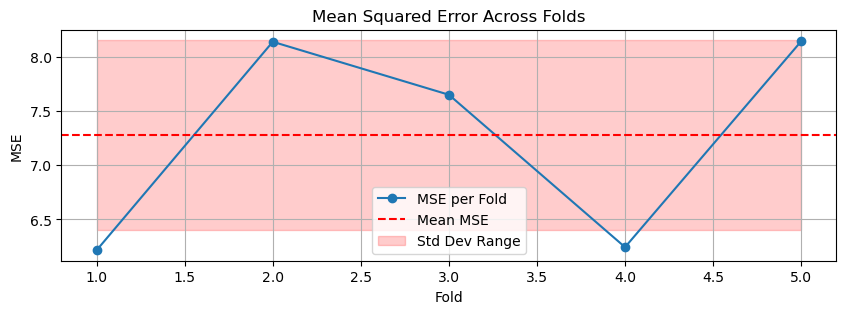

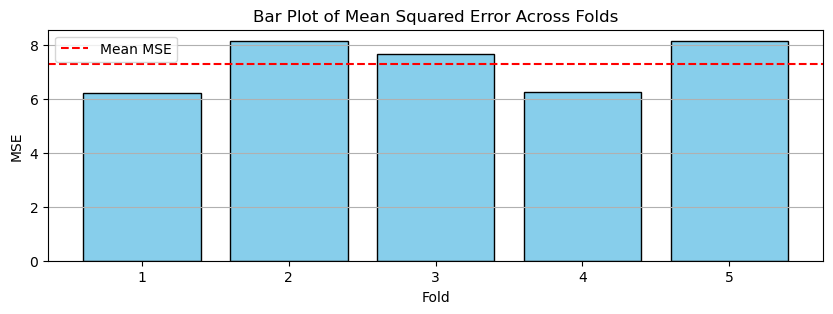

In [74]:
plt.figure(figsize=(10, 3))
plt.plot(range(1, len(mse_scores) + 1), mse_scores, marker='o', label='MSE per Fold')
plt.axhline(np.mean(mse_scores), color='r', linestyle='--', label='Mean MSE')
plt.fill_between(
    range(1, len(mse_scores) + 1),
    np.mean(mse_scores) - np.std(mse_scores),
    np.mean(mse_scores) + np.std(mse_scores),
    color='r',
    alpha=0.2,
    label='Std Dev Range'
)
plt.title('Mean Squared Error Across Folds')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 3))
plt.bar(range(1, len(mse_scores) + 1), mse_scores, color='skyblue', edgecolor='black')
plt.axhline(np.mean(mse_scores), color='r', linestyle='--', label='Mean MSE')
plt.title('Bar Plot of Mean Squared Error Across Folds')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.legend()
plt.grid(axis='y')
plt.show()


#### <a id='toc1_16_5_1_'></a>[Mean Squared Error (MSE) Across Folds (Line Plot)](#toc0_)
This plot shows the MSE values for each fold during cross-validation, with the red dashed line indicating the mean MSE and the shaded area showing the standard deviation range.

MSE varies across folds but remains within a relatively stable range. The folds with the highest and lowest MSE represent the times when the model had more or less predictive success, likely due to differences in the temporal structure of the data. The consistency of MSE across folds (no extreme outliers) indicates that the model is generally stable with log-transformed data. However, there is still room for improvement, as the MSE is non-negligible across all folds.

#### <a id='toc1_16_5_2_'></a>[Bar Plot of MSE Across Folds](#toc0_)

This chart shows the MSE for each fold, with the red dashed line indicating the mean MSE. Folds have similar MSE values, with slight variations that align with the line plot. The bars reflect relative consistency across folds, indicating that the model doesn't fail significantly in any specific time period. This visualization reaffirms the observation that the model performs consistently across different folds, though there are opportunities to reduce MSE further.

In [75]:
r2_scores = []
residuals = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    ridge_model.fit(X_train_scaled, y_train)
    y_pred = ridge_model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    residuals.append(y_test - y_pred)

print("Additional Metrics Computed:")
print(f"R² Scores: {r2_scores}")


Additional Metrics Computed:
R² Scores: [0.5587134847390536, 0.577955709173334, 0.5333383202075392, 0.6198324421745683, 0.4389874509096593]


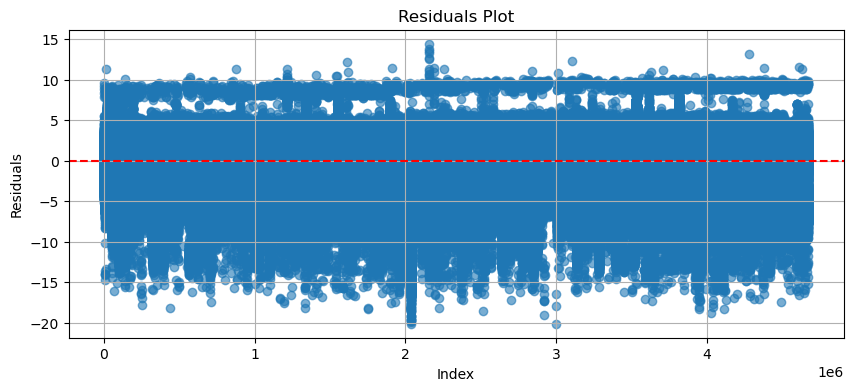

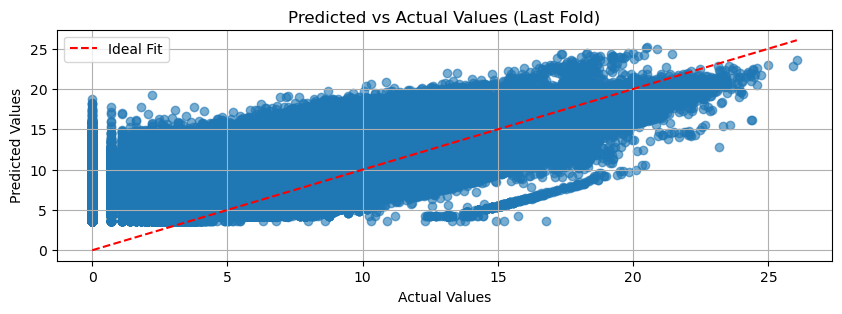

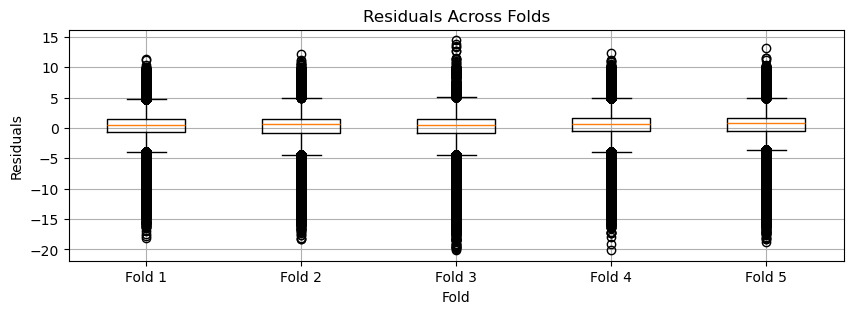

In [76]:
all_residuals = np.concatenate(residuals)

plt.figure(figsize=(10, 4))
plt.scatter(range(len(all_residuals)), all_residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.grid()
plt.show()

plt.figure(figsize=(10, 3))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.title("Predicted vs Actual Values (Last Fold)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 3))
plt.boxplot(residuals, labels=[f"Fold {i+1}" for i in range(len(residuals))])
plt.title("Residuals Across Folds")
plt.xlabel("Fold")
plt.ylabel("Residuals")
plt.grid()
plt.show()


#### <a id='toc1_16_5_3_'></a>[Residuals Plot](#toc0_)
- **What it shows**:
  - Residuals (difference between predicted and actual values) plotted against the index.
  - The red dashed line represents zero residuals (perfect predictions).

- **Key Observations**:
  - Residuals are scattered across a wide range, with some clustering near zero but notable outliers in both positive and negative directions.
  - The model occasionally overestimates or underestimates the target variable significantly.

- **Insights**:
  - The presence of extreme residuals suggests that while the model handles the majority of predictions well, certain data points are poorly predicted.
  - These outliers might indicate anomalies in the data or limitations in the model's ability to capture complex relationships.

---

#### <a id='toc1_16_5_4_'></a>[Predicted vs. Actual Values (Last Fold)](#toc0_)
- **What it shows**:
  - Scatter plot comparing predicted and actual values for the last fold.
  - The red dashed line represents the ideal case where predicted values perfectly match actual values.

- **Key Observations**:
  - Most points cluster along the diagonal line, indicating reasonable prediction accuracy.
  - There is a tendency for the model to slightly underpredict higher actual values, as seen by the scatter below the diagonal for larger actual values.

- **Insights**:
  - The underprediction of higher values suggests that the model may not fully capture the variability in high-value ranges.
  - Further tuning or additional features may help the model better handle these cases.


#### <a id='toc1_16_5_5_'></a>[Residuals Across Folds (Box Plot)](#toc0_)
- **What it shows**:
  - Box plots of residuals for each fold, showing the spread and presence of outliers.

- **Key Observations**:
  - The spread of residuals is fairly consistent across folds, with similar ranges and outliers.
  - Most residuals are close to zero, but some outliers extend significantly in both directions.

- **Insights**:
  - The consistent spread suggests that the model's performance is stable across different folds.
  - The outliers indicate specific cases where the model struggles, possibly due to missing information or inherent noise in the data.

---

### <a id='toc1_16_6_'></a>[Overall Summary](#toc0_)
- **Consistency**: The model performs consistently across folds, as evidenced by the similar MSE values and residual distributions.
- **Challenges**: The presence of residual outliers and underprediction of higher values highlight areas for improvement.
- **Next Steps**: Explore advanced models (e.g., ensemble methods) to improve predictions for higher-value ranges - Which we already did in the previous sections under Baseline Models.